In [135]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
pd.options.display.float_format = '{:,.2f}'.format


In [207]:
def obtener_full_path(directorio):
    return [os.path.join(directorio, file) for file in os.listdir(directorio)]


def plottear(df, x, y):
    fig, axis = plt.subplots(1, 1, figsize=(30, 6))
    sns.barplot(data=df, x=x, y=y, ax=axis)
    axis.set_xticklabels(axis.get_xticklabels(), rotation=90)
    plt.show()
    return fig


In [137]:
df = pd.concat(map(lambda x: pd.read_csv(x, parse_dates=[
               0], dayfirst=True), obtener_full_path('input')))
df = df.sort_values('Fecha')


# Aquí se realizará el análisis del año completo en cuanto a los gastos

In [138]:
df_salidas = df.query('Movimiento == "Salida"')
costos_por_unidades = df_salidas.groupby('Destino').sum().reset_index()
costos_por_unidades['Porcentaje Gasto'] = costos_por_unidades['Neto Total'] / \
    costos_por_unidades['Neto Total'].sum()


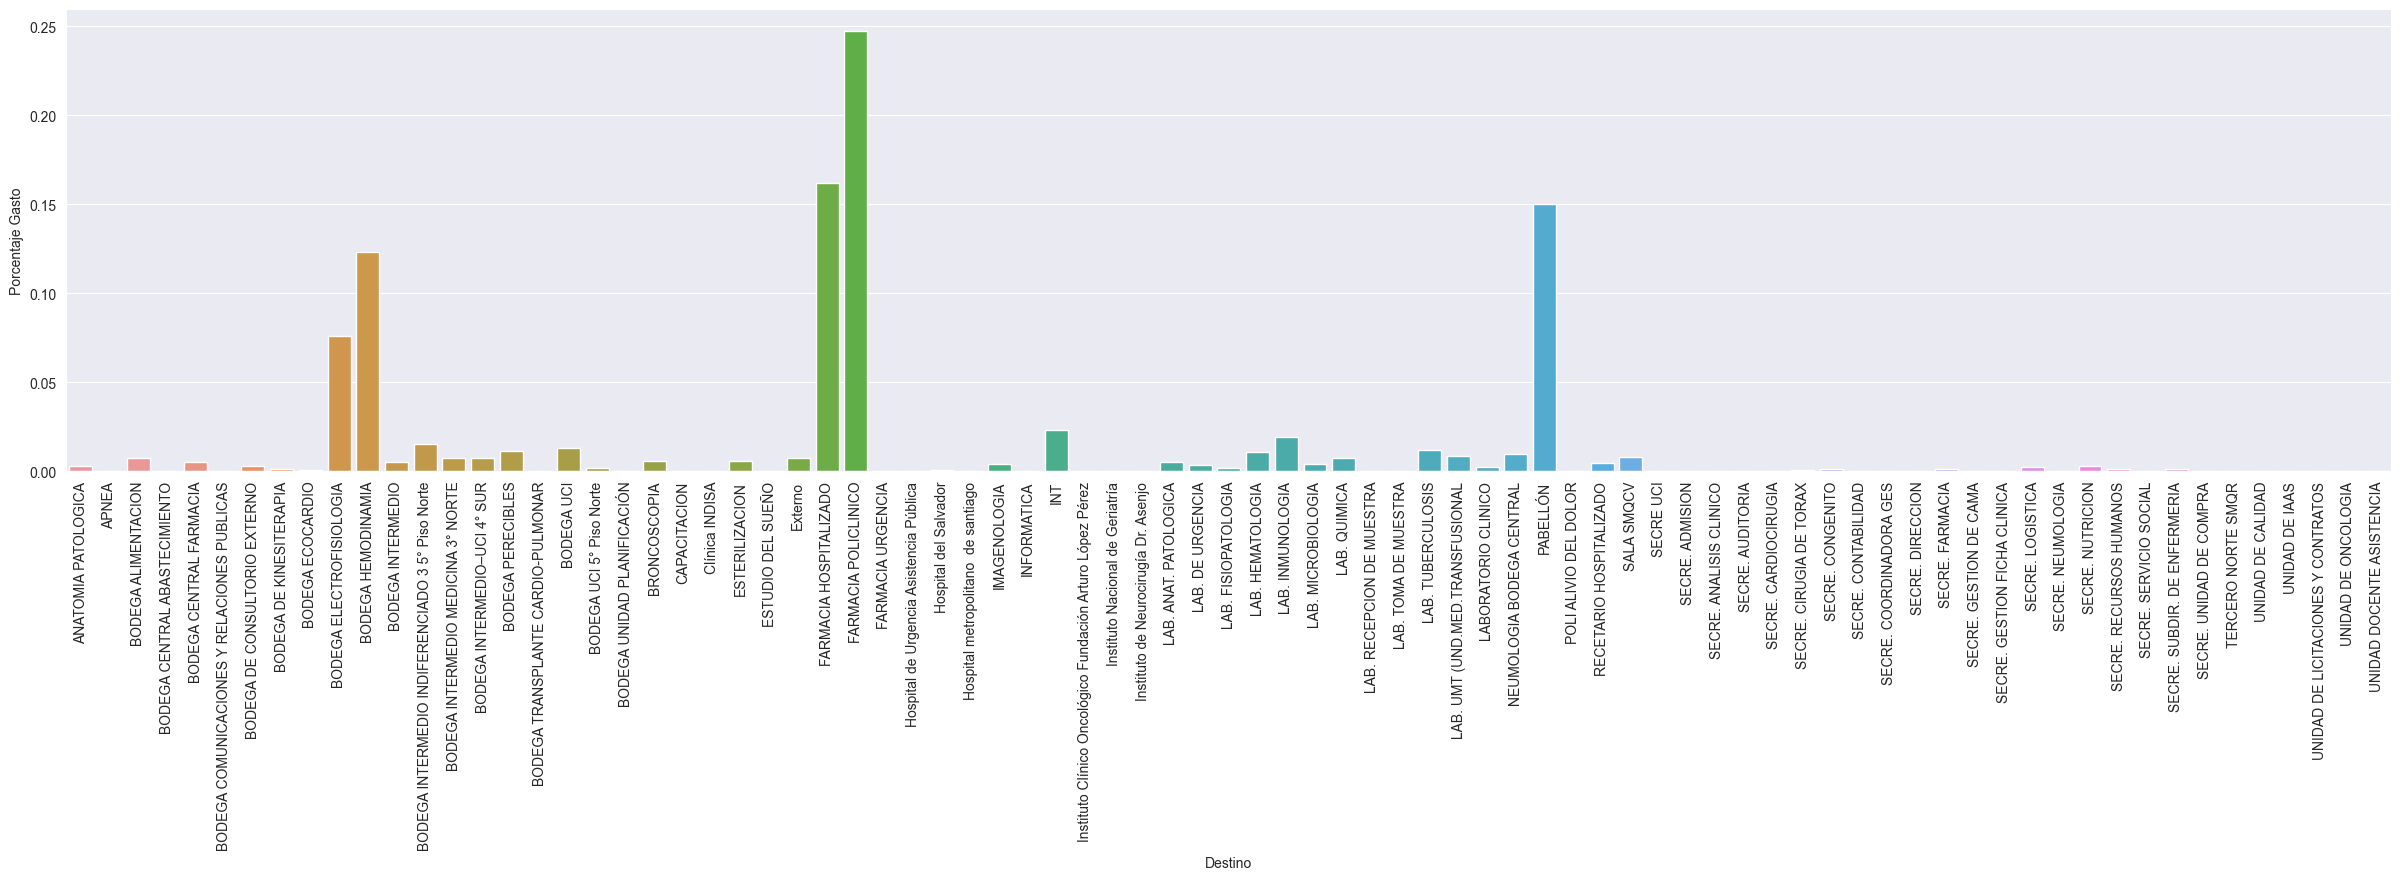

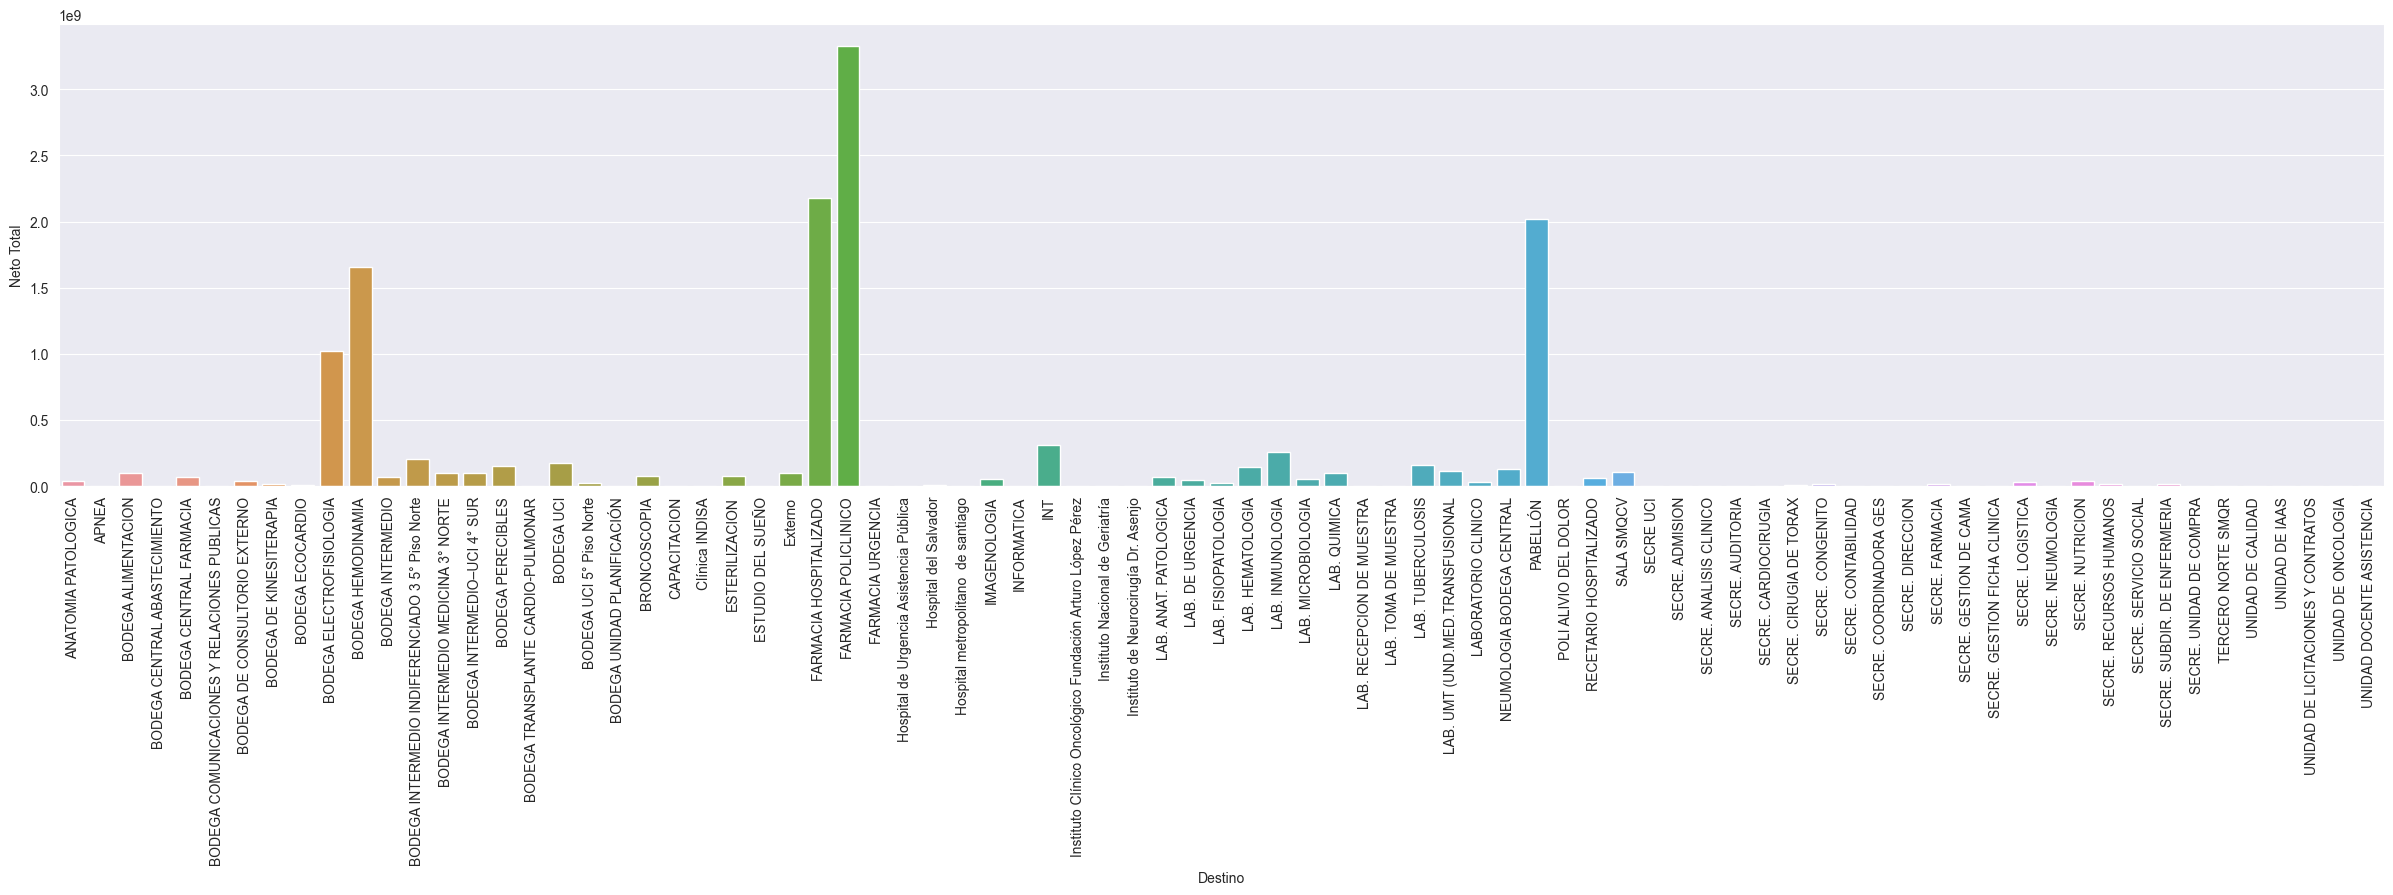

In [139]:
figura_porcentaje_global = plottear(x='Destino', y='Porcentaje Gasto', df=costos_por_unidades)
figura_gasto_neto_global = plottear(x='Destino', y='Neto Total', df=costos_por_unidades)


In [140]:
gastos_mayores_a_1000000000 = costos_por_unidades.query('`Neto Total` >= 1000000000')
gastos_menores_a_1000000000 = costos_por_unidades.query('`Neto Total` < 1000000000')


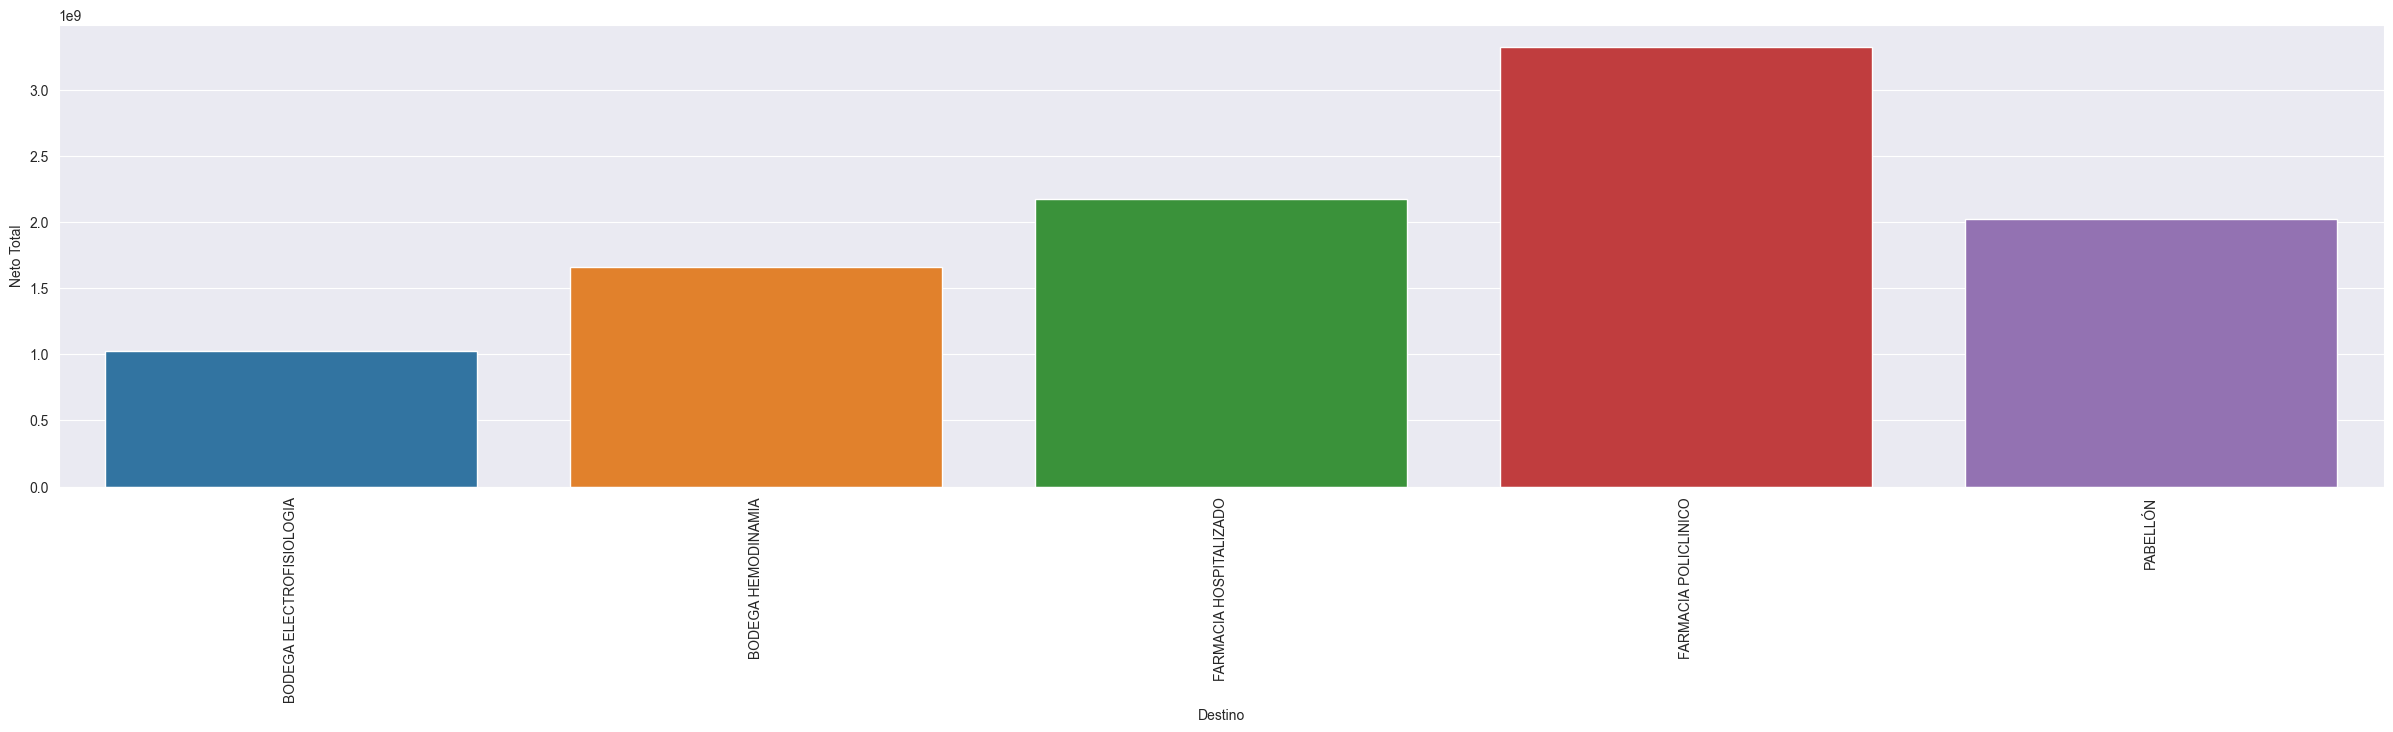

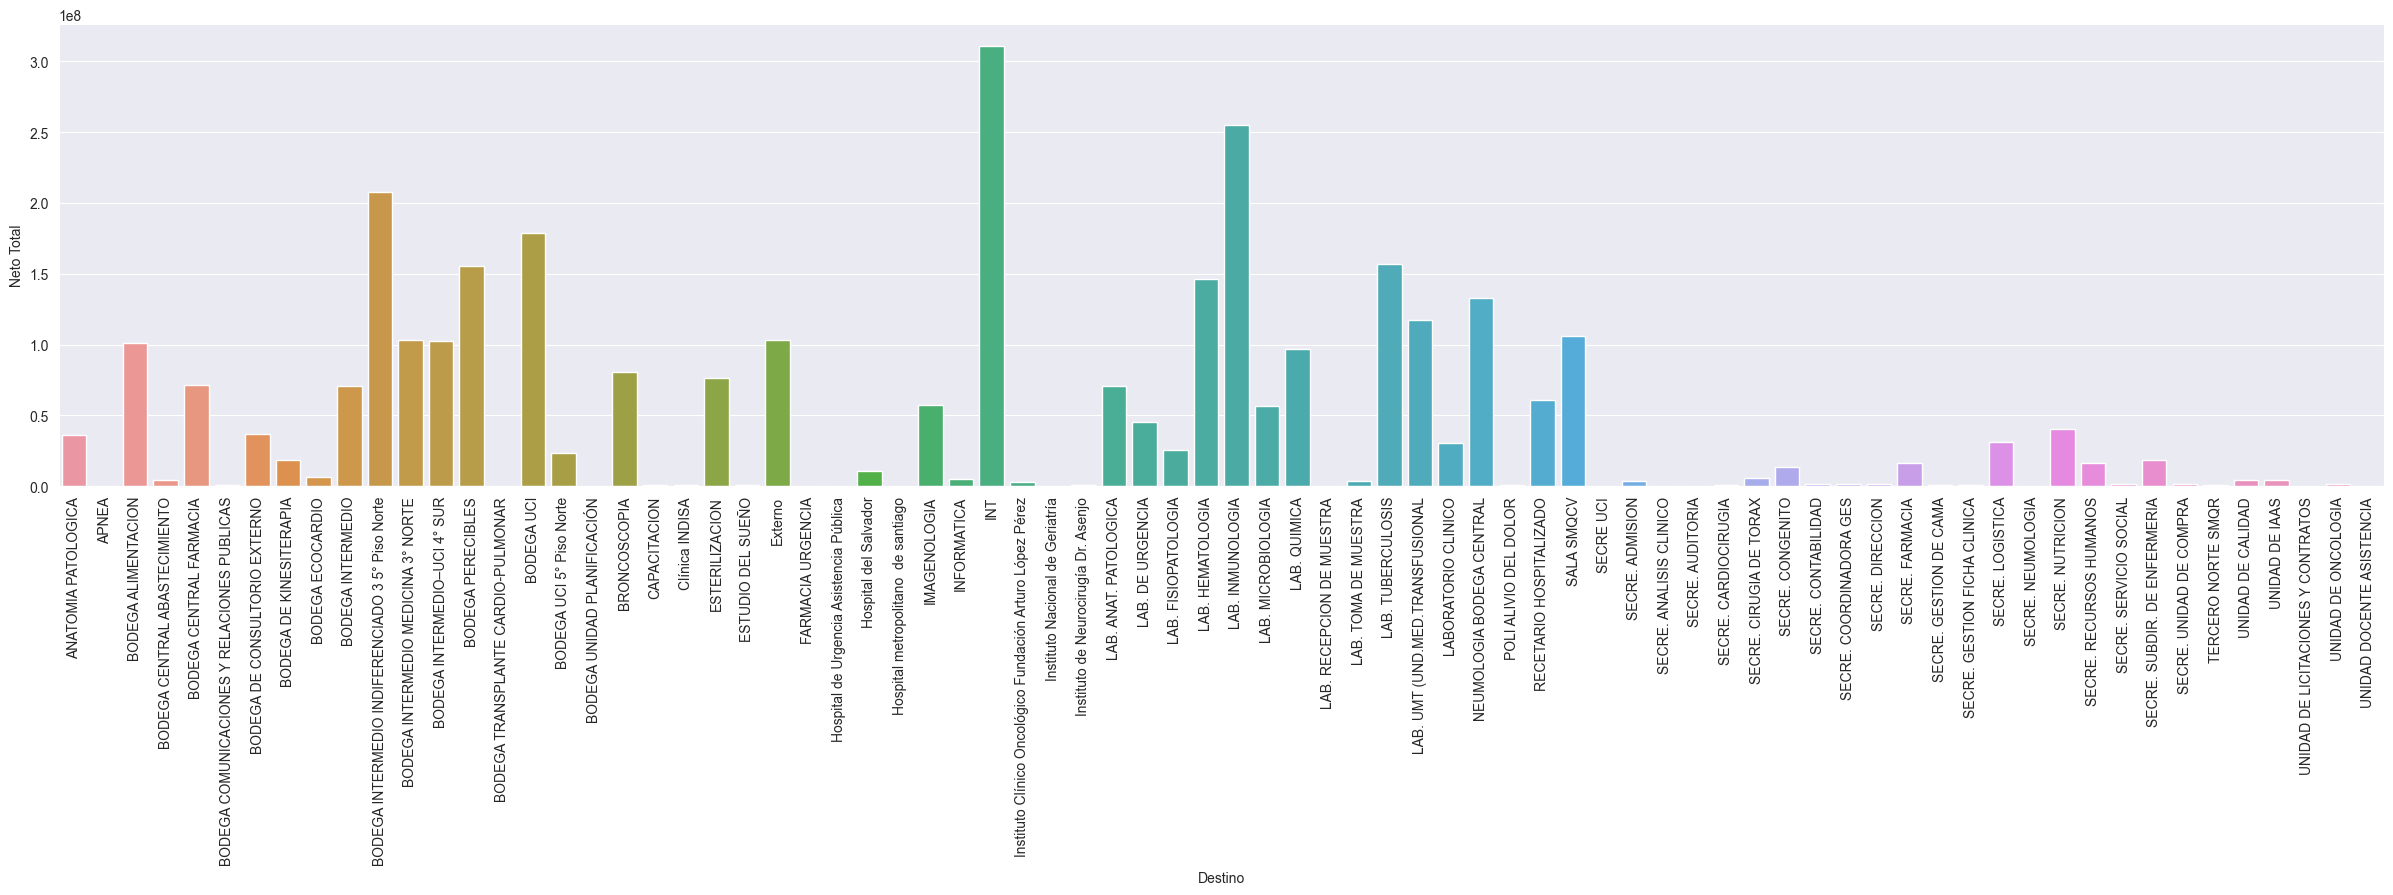

In [141]:
figura_gastos_mayores_a_1e9_total = plottear(
    x='Destino', y='Neto Total', df=gastos_mayores_a_1000000000)
figura_gastos_menores_a_1e9_total = plottear(
    x='Destino', y='Neto Total', df=gastos_menores_a_1000000000)


# En este apartado se realizará el análisis de desglose de artículos por servicio. Se observará
# cuales son los artículos que gastan más.

1. En primer lugar, se obtiene el df de los movimientos del servicio que se quiere analizar.
En este apartado se filtran los artículos que tengan una cantidad de 0 (aunque, por qué tienen
una cantidad de 0?)
2. Luego, se obtiene la suma por artículo utilizando un groupby, y sumando.
3. Finalmente, se grafica, ocupando ```x = "Nombre" e y = "Neto Total"```

De esta análisis se quieren responder las siguientes preguntas:

- ¿Cuántos artículos ha solicitado el servicio?
- ¿Cuáles son los 5 artículos que gastan más?

In [216]:
def obtener_gasto_por_servicio(df_salidas, servicio):
    movimientos_servicio = df_salidas.query('Destino == @servicio and Cantidad > 0')
    articulos_servicio_suma = movimientos_servicio.groupby('Nombre') \
                                                  .sum() \
                                                  .reset_index() \
        # .sort_values('Neto Total', ascending=False)

    diez_mas_gastadores = articulos_servicio_suma.sort_values(
        'Neto Total', ascending=False).head(10)
    diez_menos_gastadores = articulos_servicio_suma.sort_values(
        'Neto Total', ascending=False).tail(10)

    print(f'Los 10 artículos que más gastan en {servicio} son:\n'
          f'{diez_mas_gastadores.to_markdown(floatfmt=",.2f")}\n')

    print(f'Los 10 artículos que menos gastan en {servicio} son:\n'
          f'{diez_menos_gastadores.to_markdown(floatfmt=",.2f")}\n')

    figura_articulos_servicio_suma = plottear(
        x='Nombre', y='Neto Total', df=articulos_servicio_suma)

    articulos_qmin, articulos_q1, articulos_q2, articulos_q3, articulos_qmax, \
        figura_df_articulos_min_q1, figura_df_articulos_q1_q2, \
        figura_df_articulos_q2_q3, figura_df_articulos_q3_max = separar_por_cuartil(articulos_servicio_suma)
    


def separar_por_cuartil(articulos_servicio_suma):
    descripcion_neto_total = articulos_servicio_suma['Neto Total'].describe()
    print(f'La distribución de datos de la columna Neto Total es:\n\n'
          f'{descripcion_neto_total}')

    articulos_qmin = articulos_servicio_suma['Neto Total'].quantile(0)
    articulos_q1 = articulos_servicio_suma['Neto Total'].quantile(0.25)
    articulos_q2 = articulos_servicio_suma['Neto Total'].quantile(0.5)
    articulos_q3 = articulos_servicio_suma['Neto Total'].quantile(0.75)
    articulos_qmax = articulos_servicio_suma['Neto Total'].quantile(1)

    df_articulos_min_q1 = articulos_servicio_suma.query(
        '`Neto Total` >= @articulos_qmin and `Neto Total` < @articulos_q1')
    df_articulos_q1_q2 = articulos_servicio_suma.query(
        '`Neto Total` >= @articulos_q1 and `Neto Total` < @articulos_q2')
    df_articulos_q2_q3 = articulos_servicio_suma.query(
        '`Neto Total` >= @articulos_q2 and `Neto Total` < @articulos_q3')
    df_articulos_q3_max = articulos_servicio_suma.query(
        '`Neto Total` >= @articulos_q3 and `Neto Total` <= @articulos_qmax')

    figura_df_articulos_min_q1 = plottear(df_articulos_min_q1, 'Nombre', 'Neto Total')
    figura_df_articulos_q1_q2 = plottear(df_articulos_q1_q2, 'Nombre', 'Neto Total')
    figura_df_articulos_q2_q3 = plottear(df_articulos_q2_q3, 'Nombre', 'Neto Total')
    figura_df_articulos_q3_max = plottear(df_articulos_q3_max, 'Nombre', 'Neto Total')

    return articulos_qmin, articulos_q1, articulos_q2, articulos_q3, articulos_qmax, \
        figura_df_articulos_min_q1, figura_df_articulos_q1_q2, \
        figura_df_articulos_q2_q3, figura_df_articulos_q3_max


Los 10 artículos que más gastan en FARMACIA POLICLINICO son:
|     | Nombre                                                      |   Cantidad |   Neto Unitario |     Neto Total |
|----:|:------------------------------------------------------------|-----------:|----------------:|---------------:|
| 114 | ILOPROST 10 MCG AMP 1 ML (VENTAVIS)                         |      48442 |      587,781.00 | 544,721,562.00 |
|  19 | AMBRISENTAN 10 MG                                           |      17940 |      448,520.00 | 361,641,600.00 |
| 202 | RH-DORNASA-ALFA 2,5MG/2ML AMPOLLA                           |      16800 |      170,100.00 | 357,210,000.00 |
| 229 | TOBRAMICINA 28 MG CAP INHALACION                            |      33600 |      141,327.83 | 167,327,018.88 |
| 237 | TRIKAFTA ( elexacaftor, tezacaftor, ivacaftor)              |        588 |      277,414.42 | 163,119,678.96 |
| 180 | OSIMERTINIB 80 MG COMPRIMIDO                                |       1080 |      780,000.00 | 140,400,000.

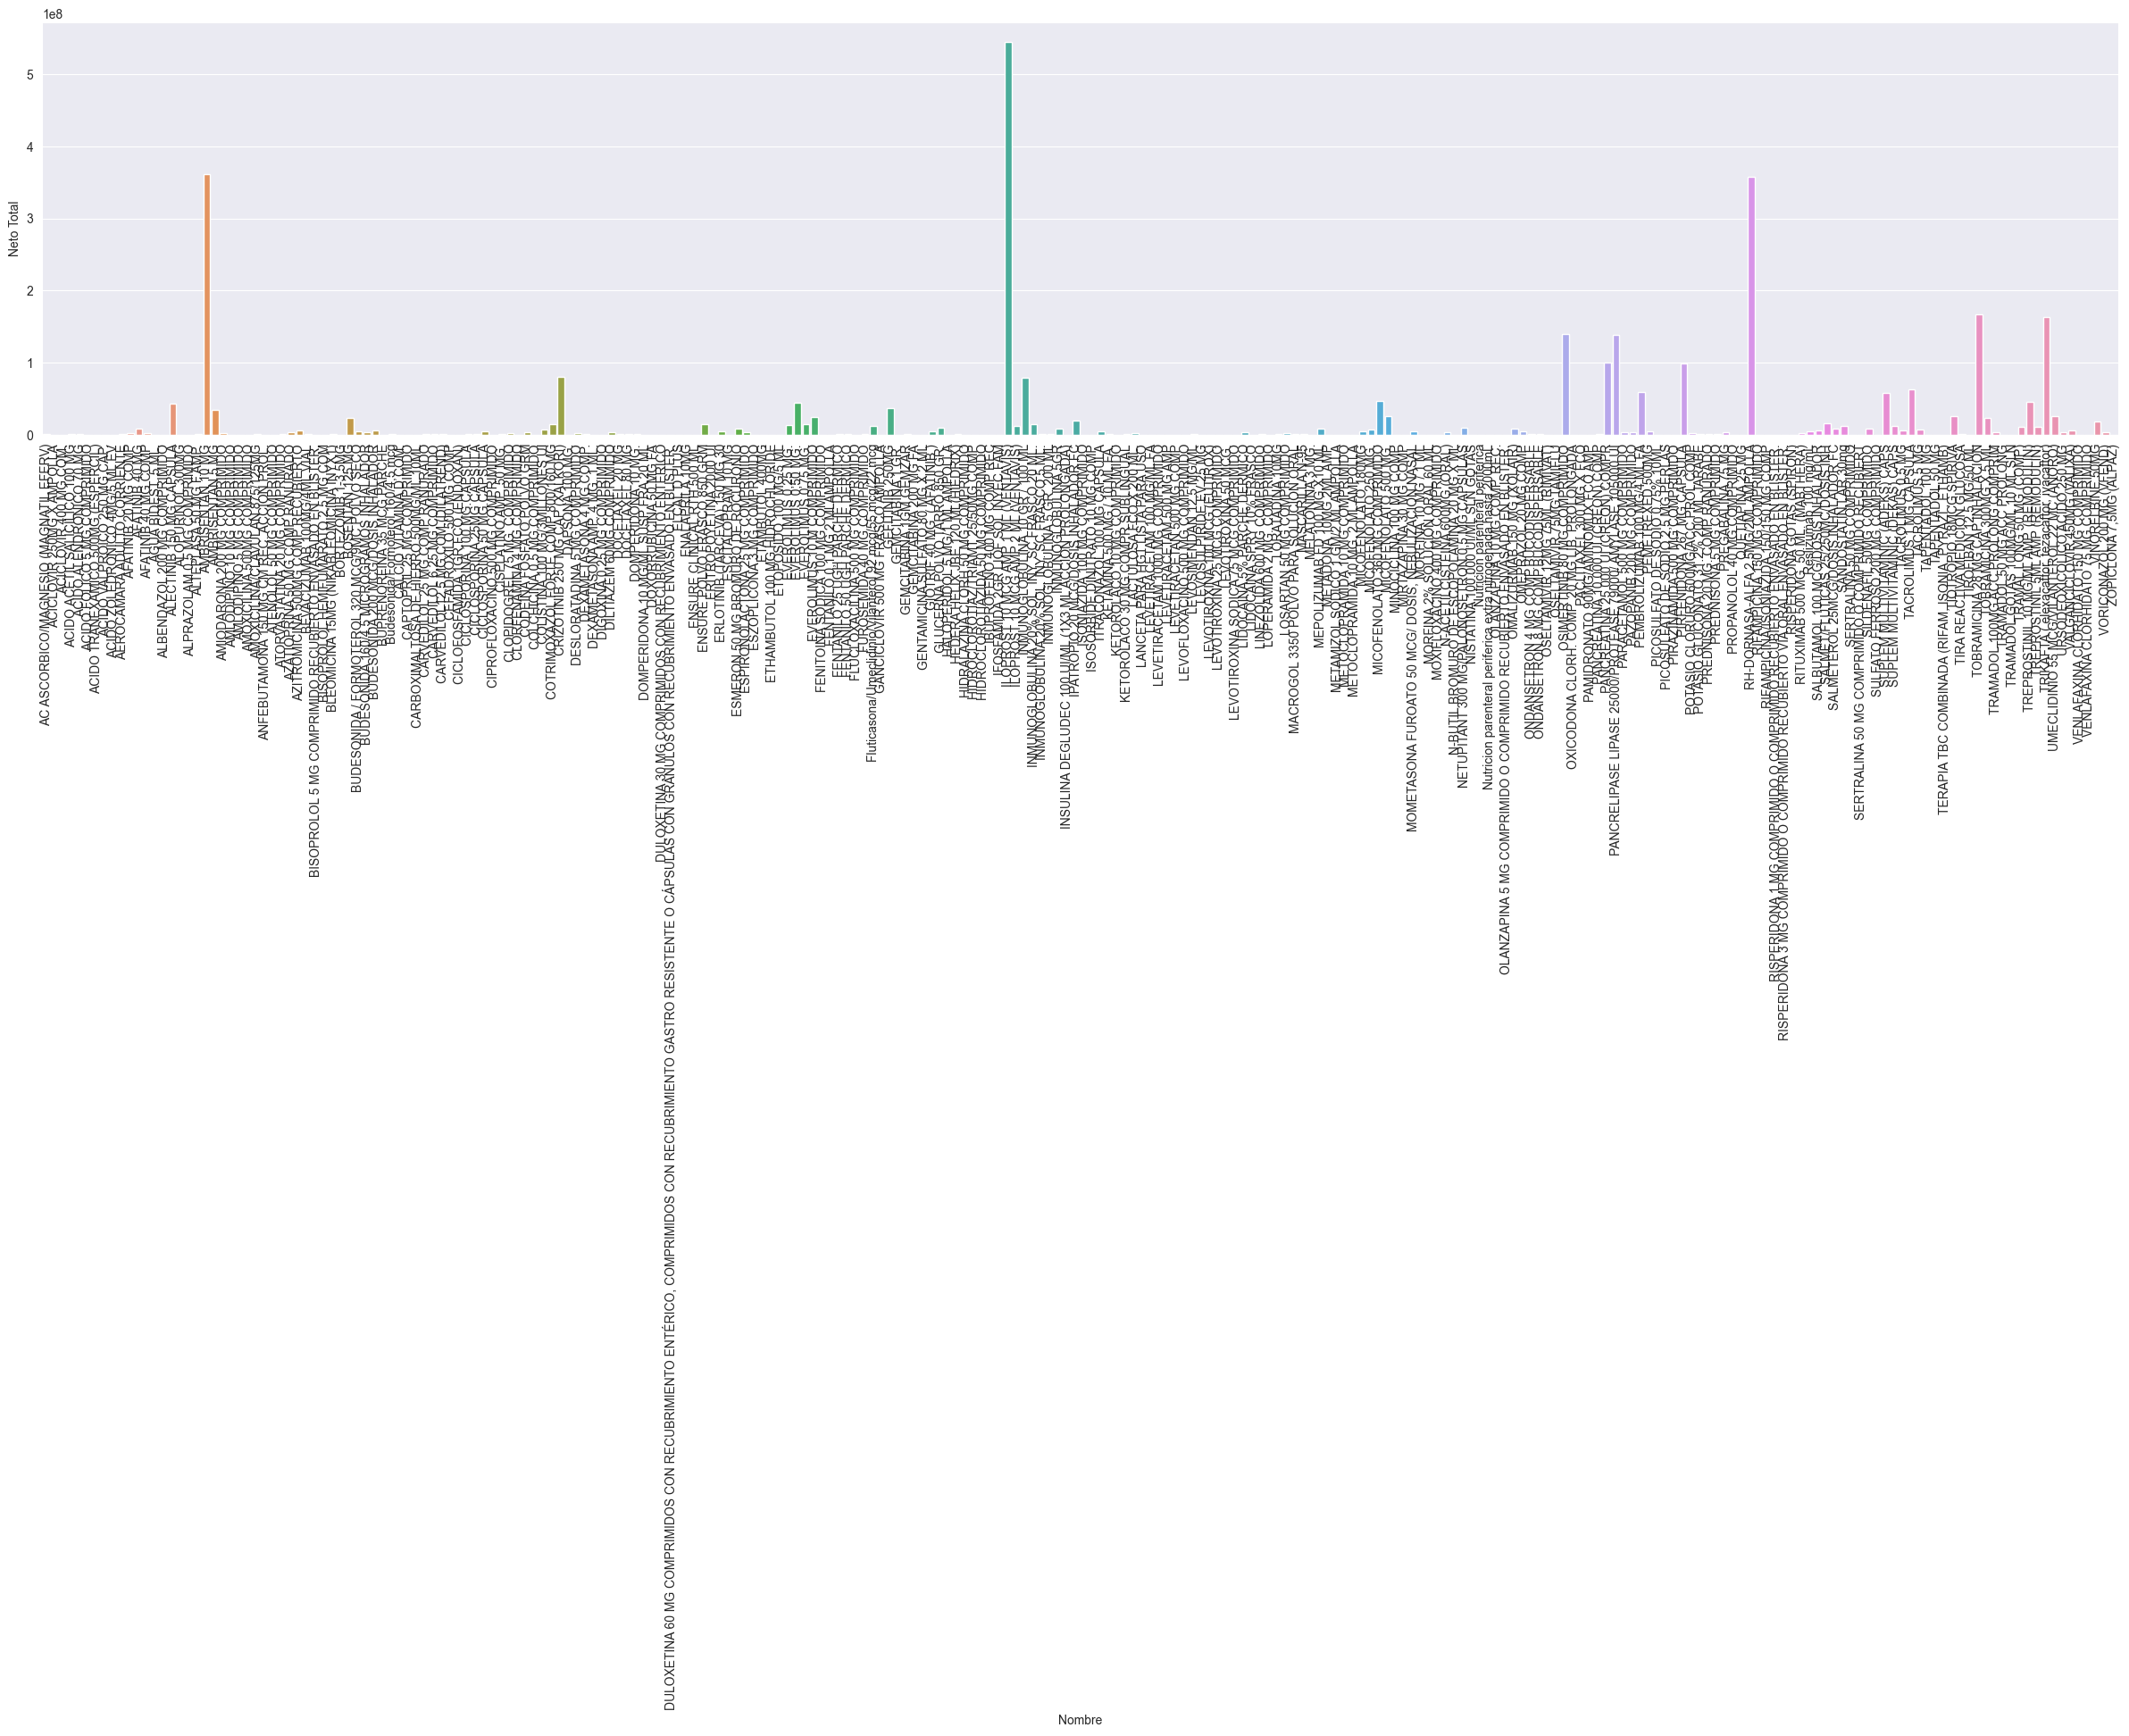

La distribución de datos de la columna Neto Total es:

count           246.00
mean     13,515,896.77
std      52,141,162.51
min               0.00
25%         106,282.50
50%         783,800.00
75%       4,693,281.25
max     544,721,562.00
Name: Neto Total, dtype: float64


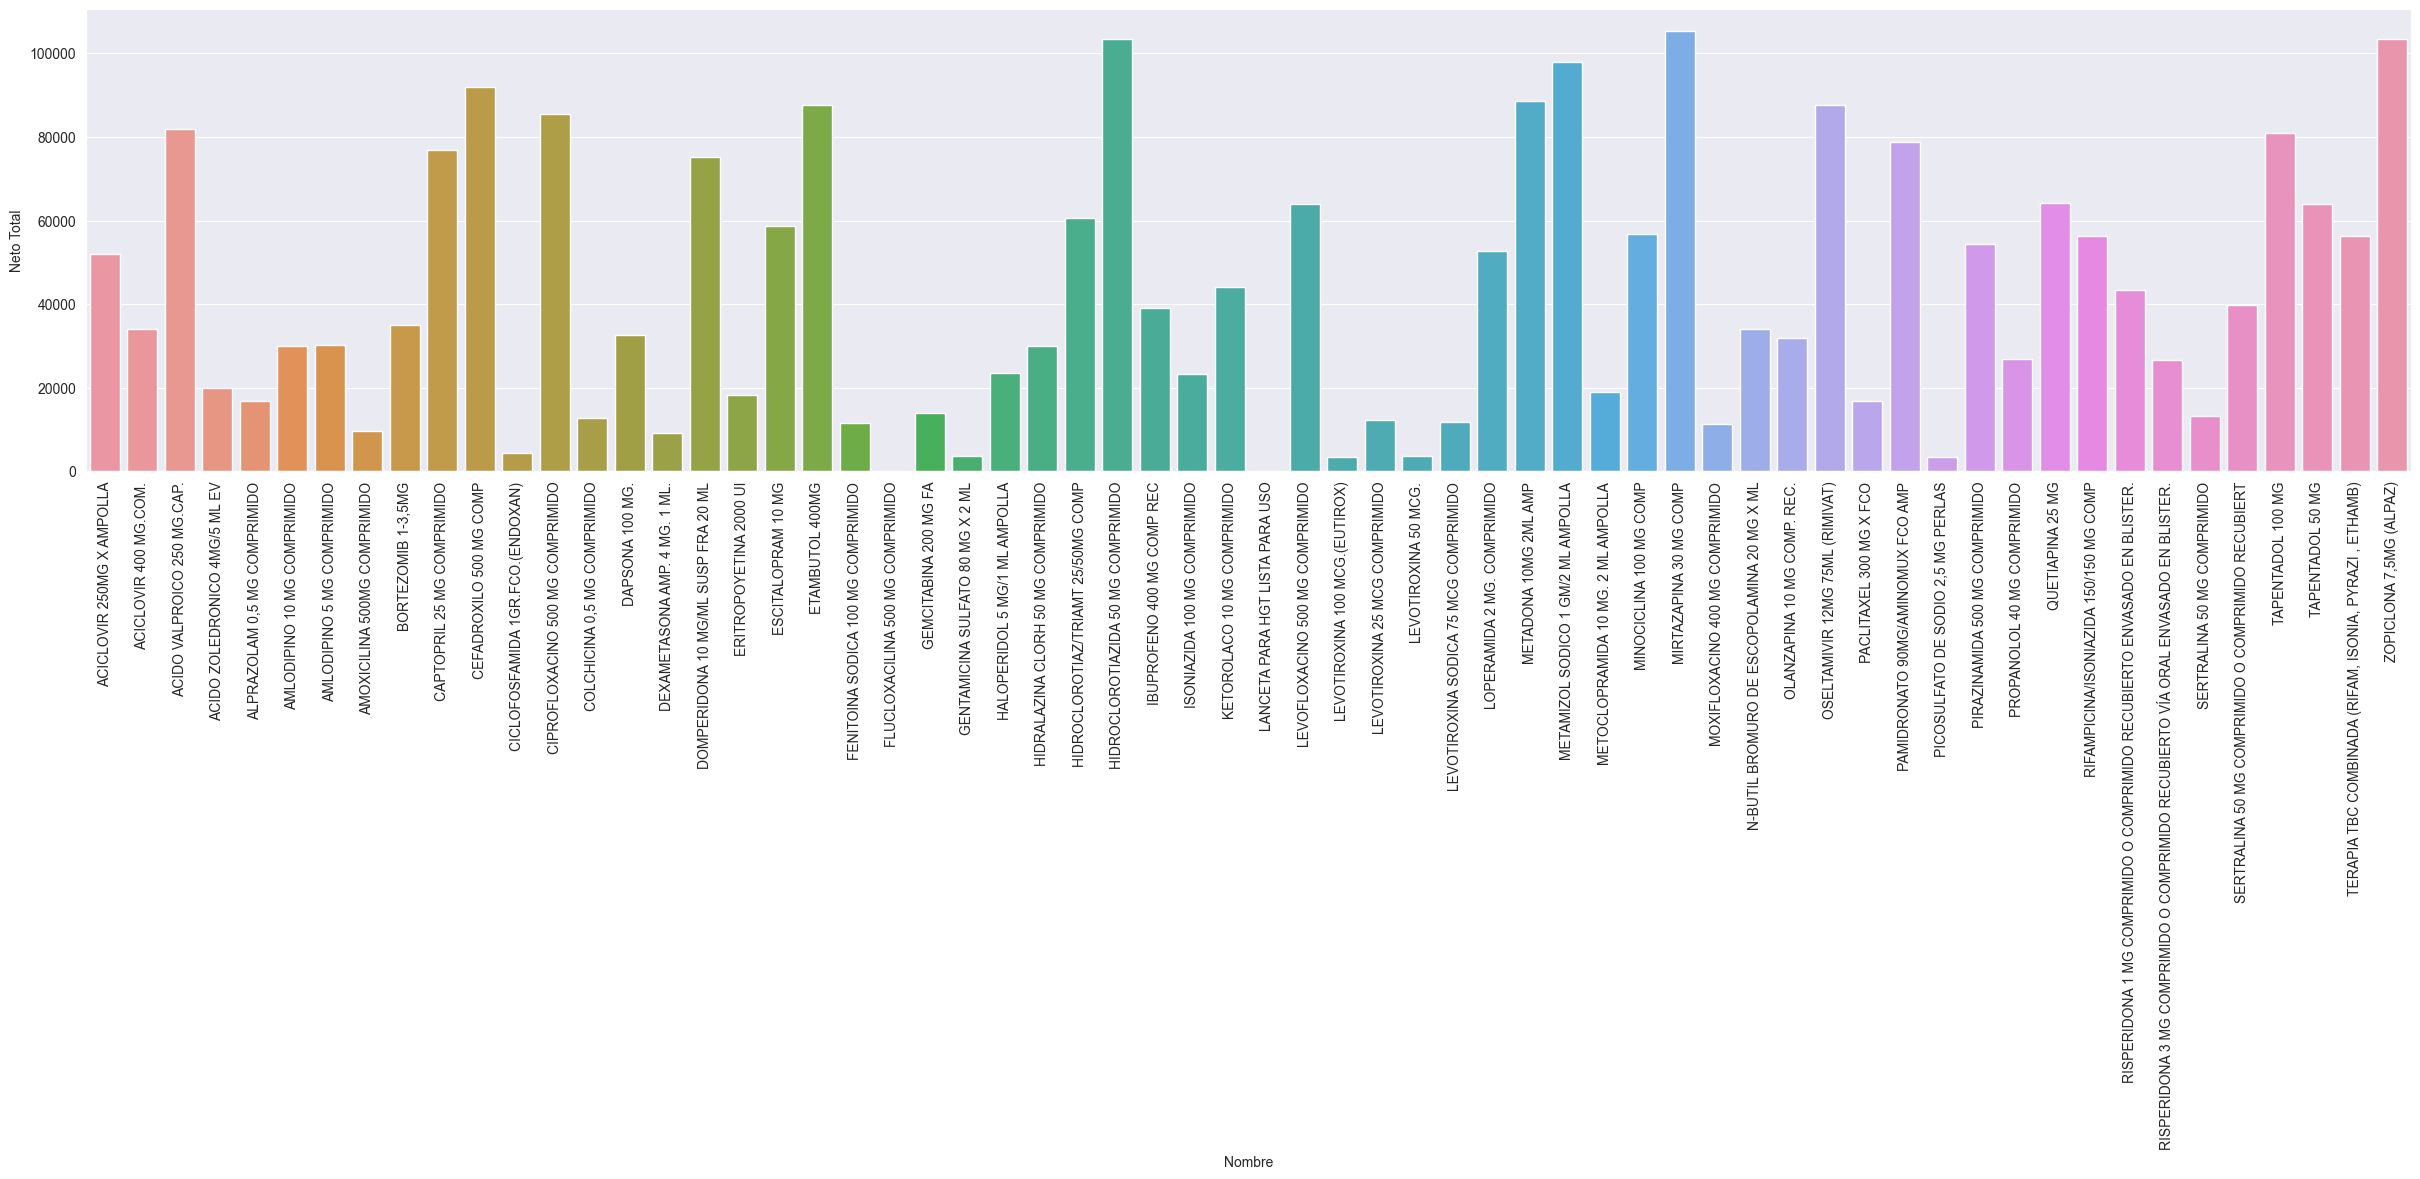

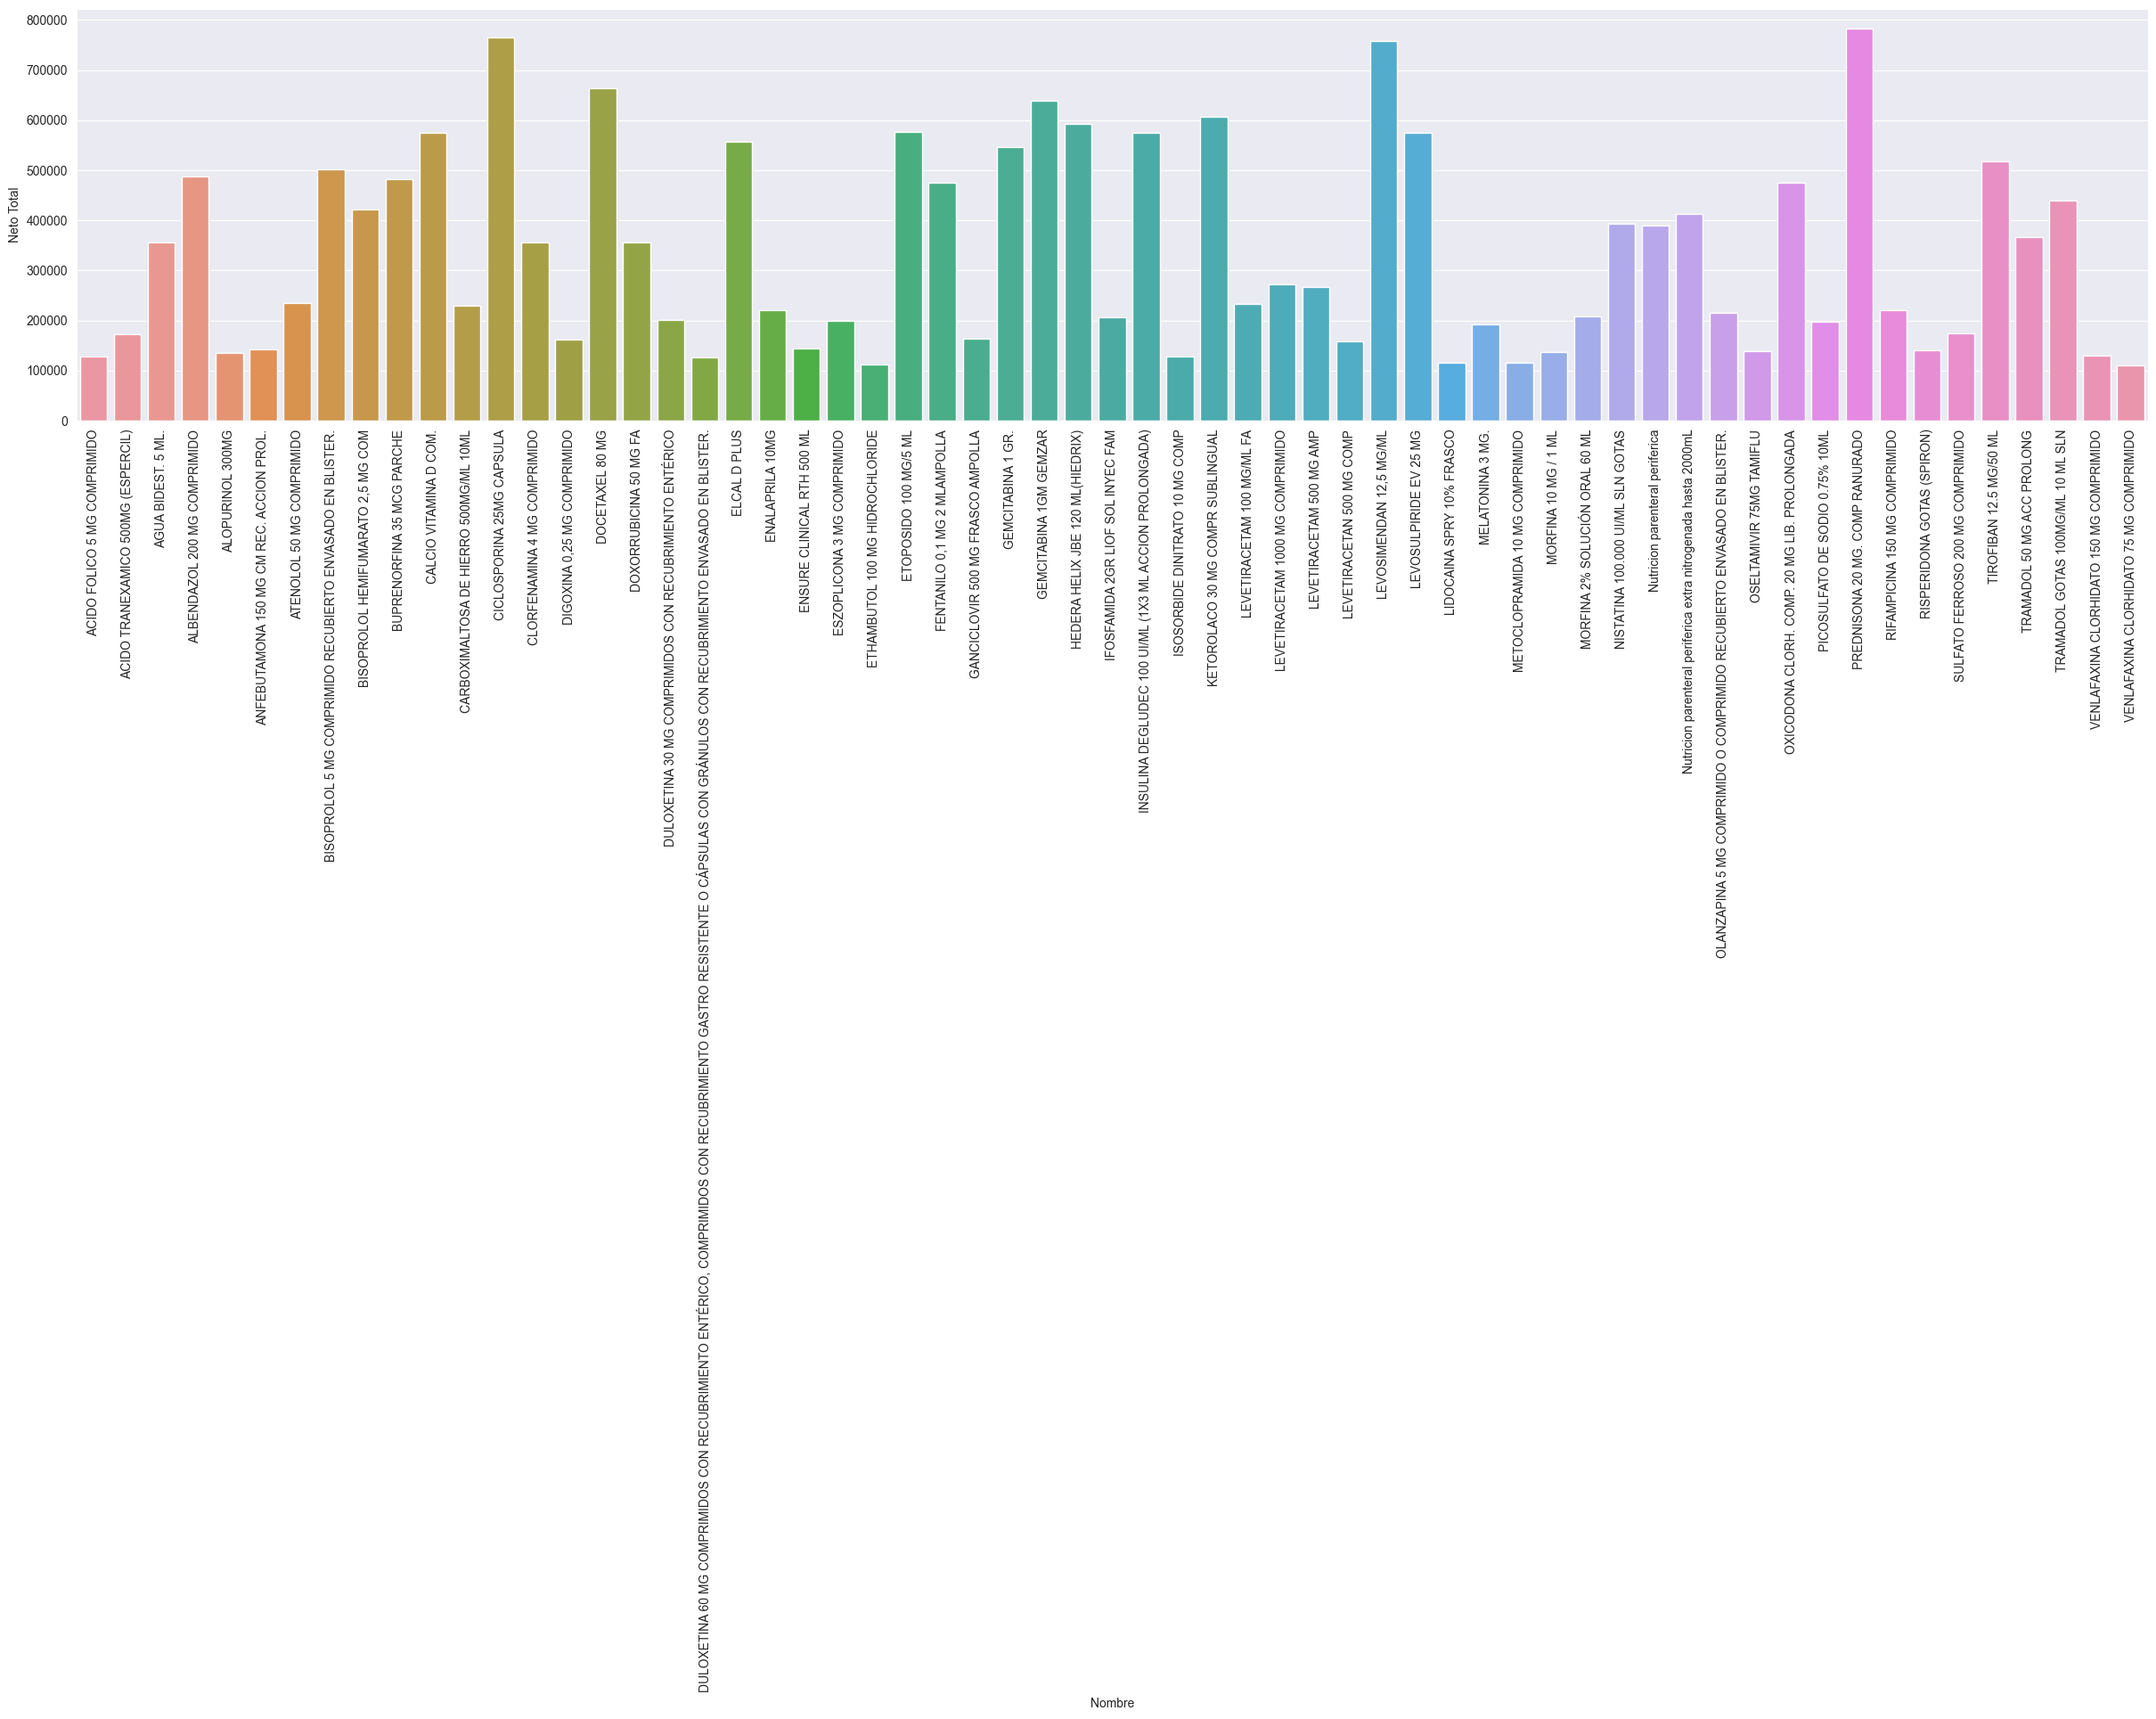

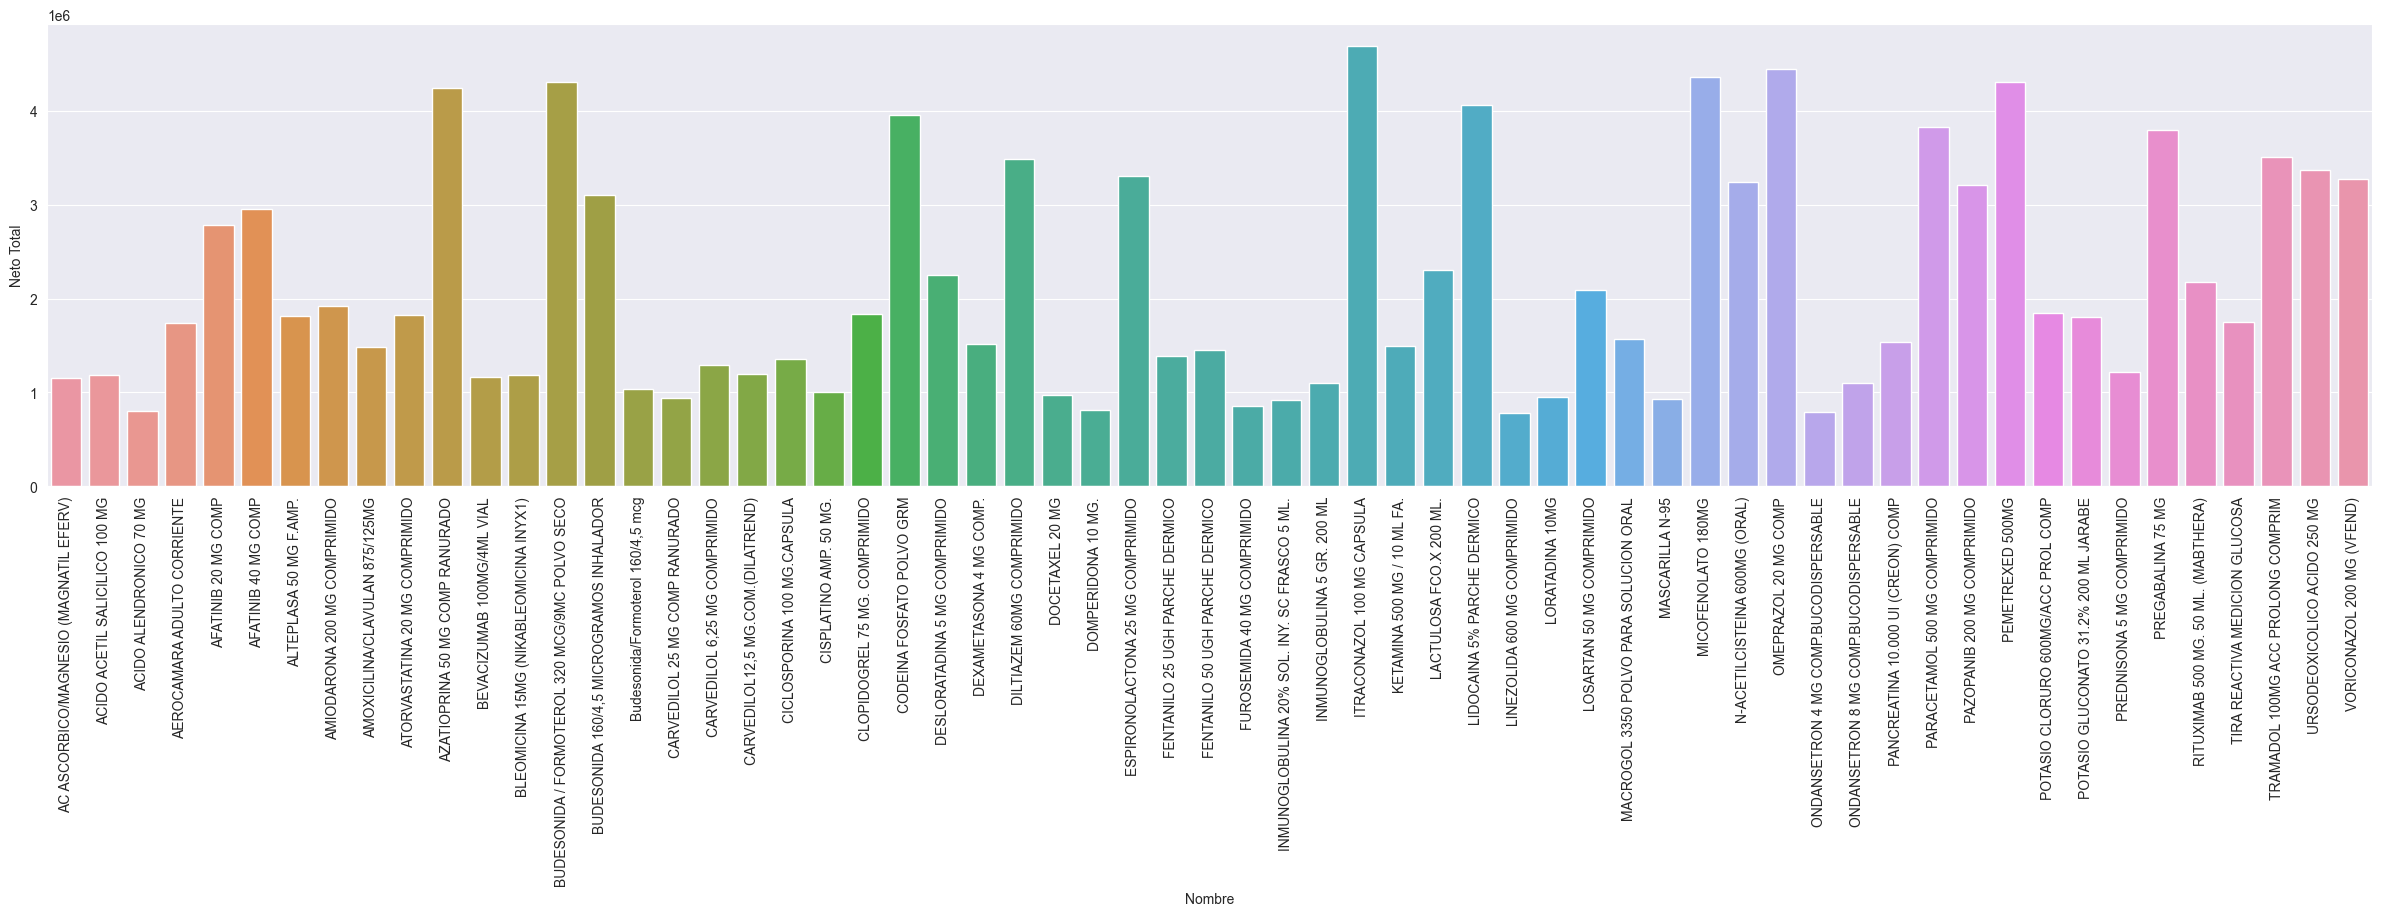

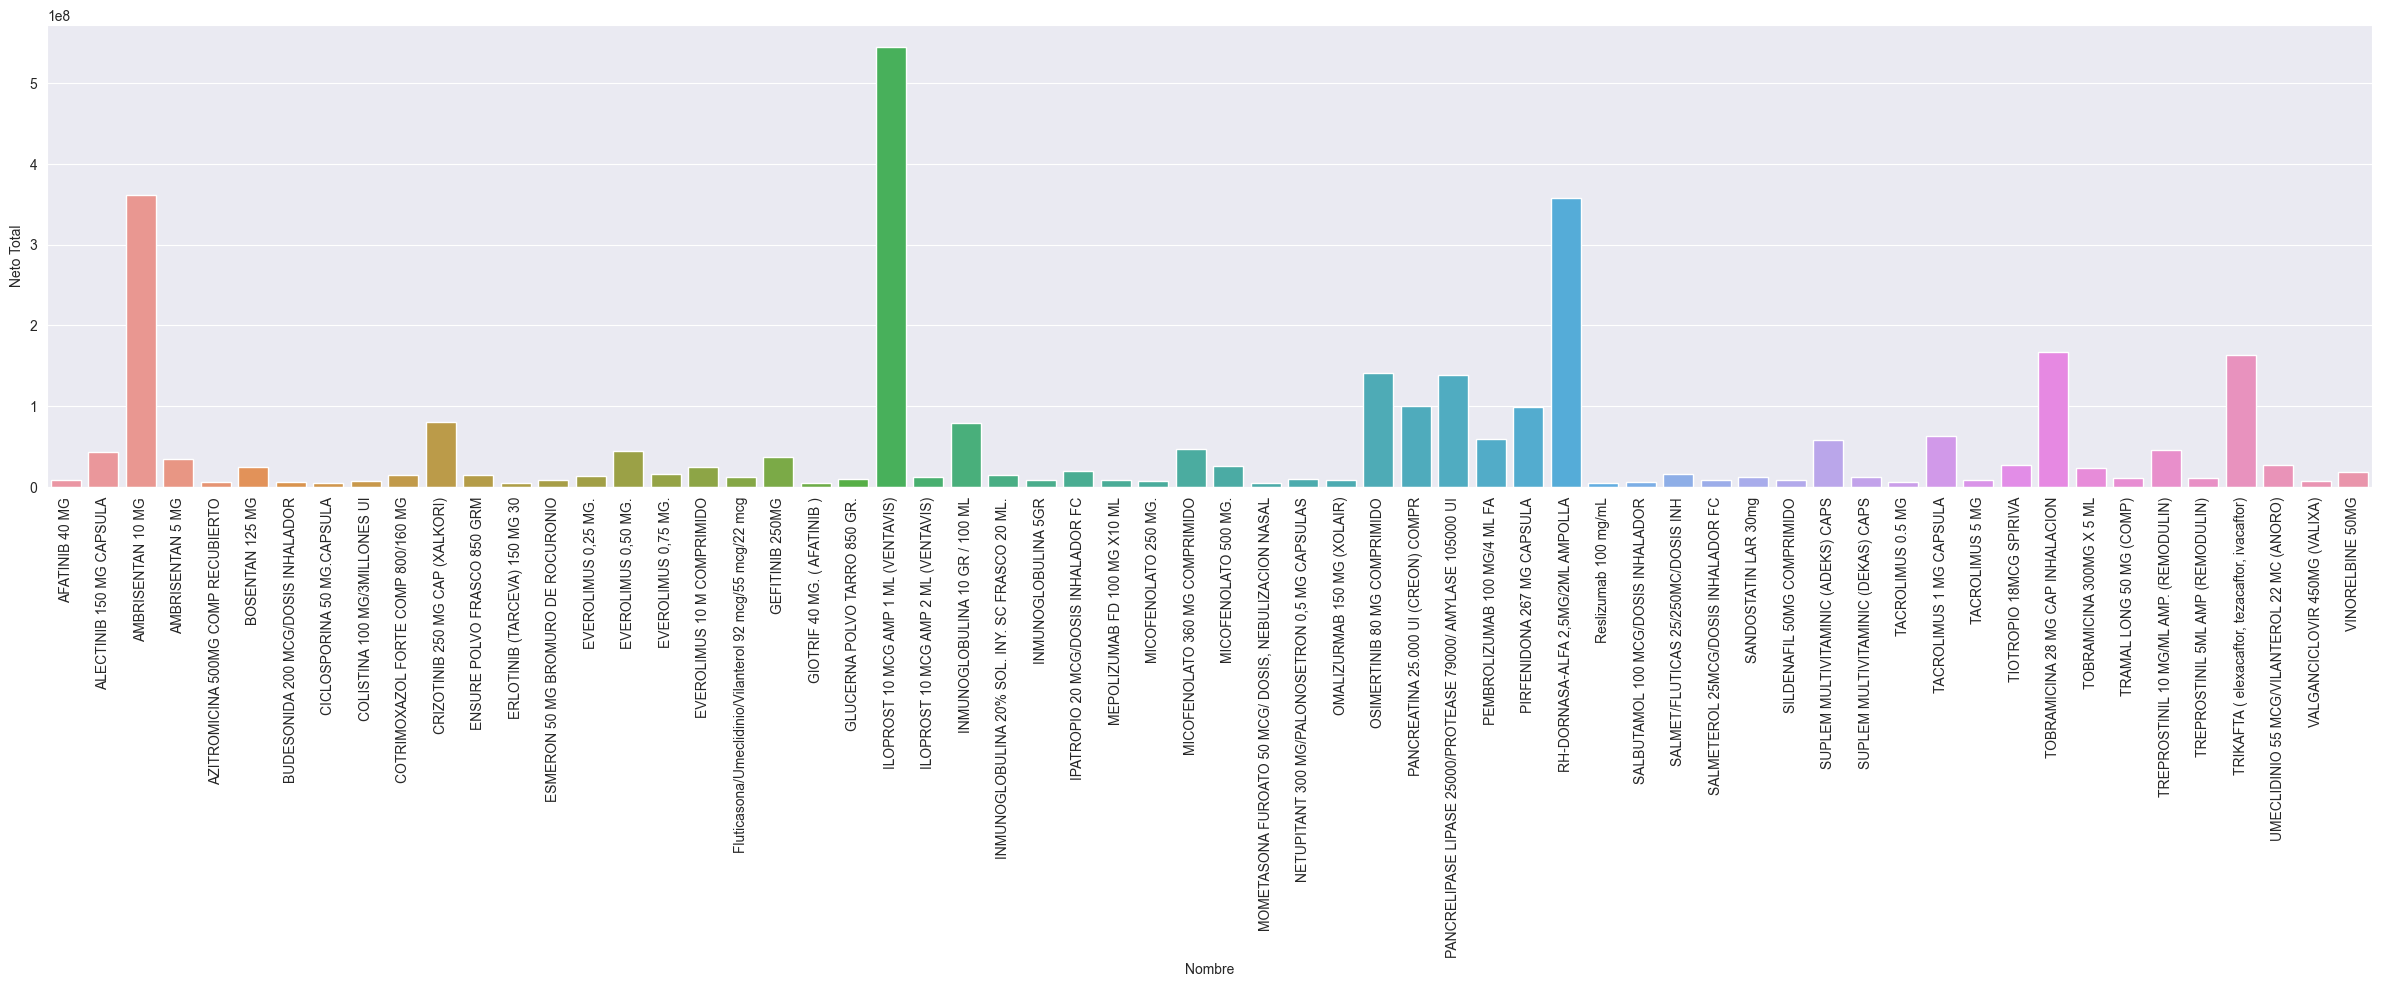

In [218]:
obtener_gasto_por_servicio(df_salidas, "FARMACIA POLICLINICO")

In [150]:
movimientos_farmacia_poli = df_salidas.query('Destino == "FARMACIA POLICLINICO" and '
                                             'Cantidad > 0')

articulos_servicio_suma = movimientos_farmacia_poli.groupby('Nombre') \
                                                   .sum() \
                                                   .reset_index() \
                                                   .sort_values('Neto Total', ascending=False)


In [214]:
diez_mas_gastadores = articulos_servicio_suma.head(10)
diez_menos_gastadores = articulos_servicio_suma.tail(10)

print(f'Los 10 artículos que más gastan en el servicio son:\n'
      f'{diez_mas_gastadores.to_markdown(floatfmt=",.2f")}\n')


print(f'Los 10 artículos que menos gastan en el servicio son:\n'
      f'{diez_menos_gastadores.to_markdown(floatfmt=",.2f")}\n')


Los 10 artículos que más gastan en el servicio son:
|     | Nombre                                                      |   Cantidad |   Neto Unitario |     Neto Total |
|----:|:------------------------------------------------------------|-----------:|----------------:|---------------:|
| 114 | ILOPROST 10 MCG AMP 1 ML (VENTAVIS)                         |      48442 |      587,781.00 | 544,721,562.00 |
|  19 | AMBRISENTAN 10 MG                                           |      17940 |      448,520.00 | 361,641,600.00 |
| 202 | RH-DORNASA-ALFA 2,5MG/2ML AMPOLLA                           |      16800 |      170,100.00 | 357,210,000.00 |
| 229 | TOBRAMICINA 28 MG CAP INHALACION                            |      33600 |      141,327.83 | 167,327,018.88 |
| 237 | TRIKAFTA ( elexacaftor, tezacaftor, ivacaftor)              |        588 |      277,414.42 | 163,119,678.96 |
| 180 | OSIMERTINIB 80 MG COMPRIMIDO                                |       1080 |      780,000.00 | 140,400,000.00 |
| 18

## Ahora, se obtendrá una distribución por producto global del servicio.

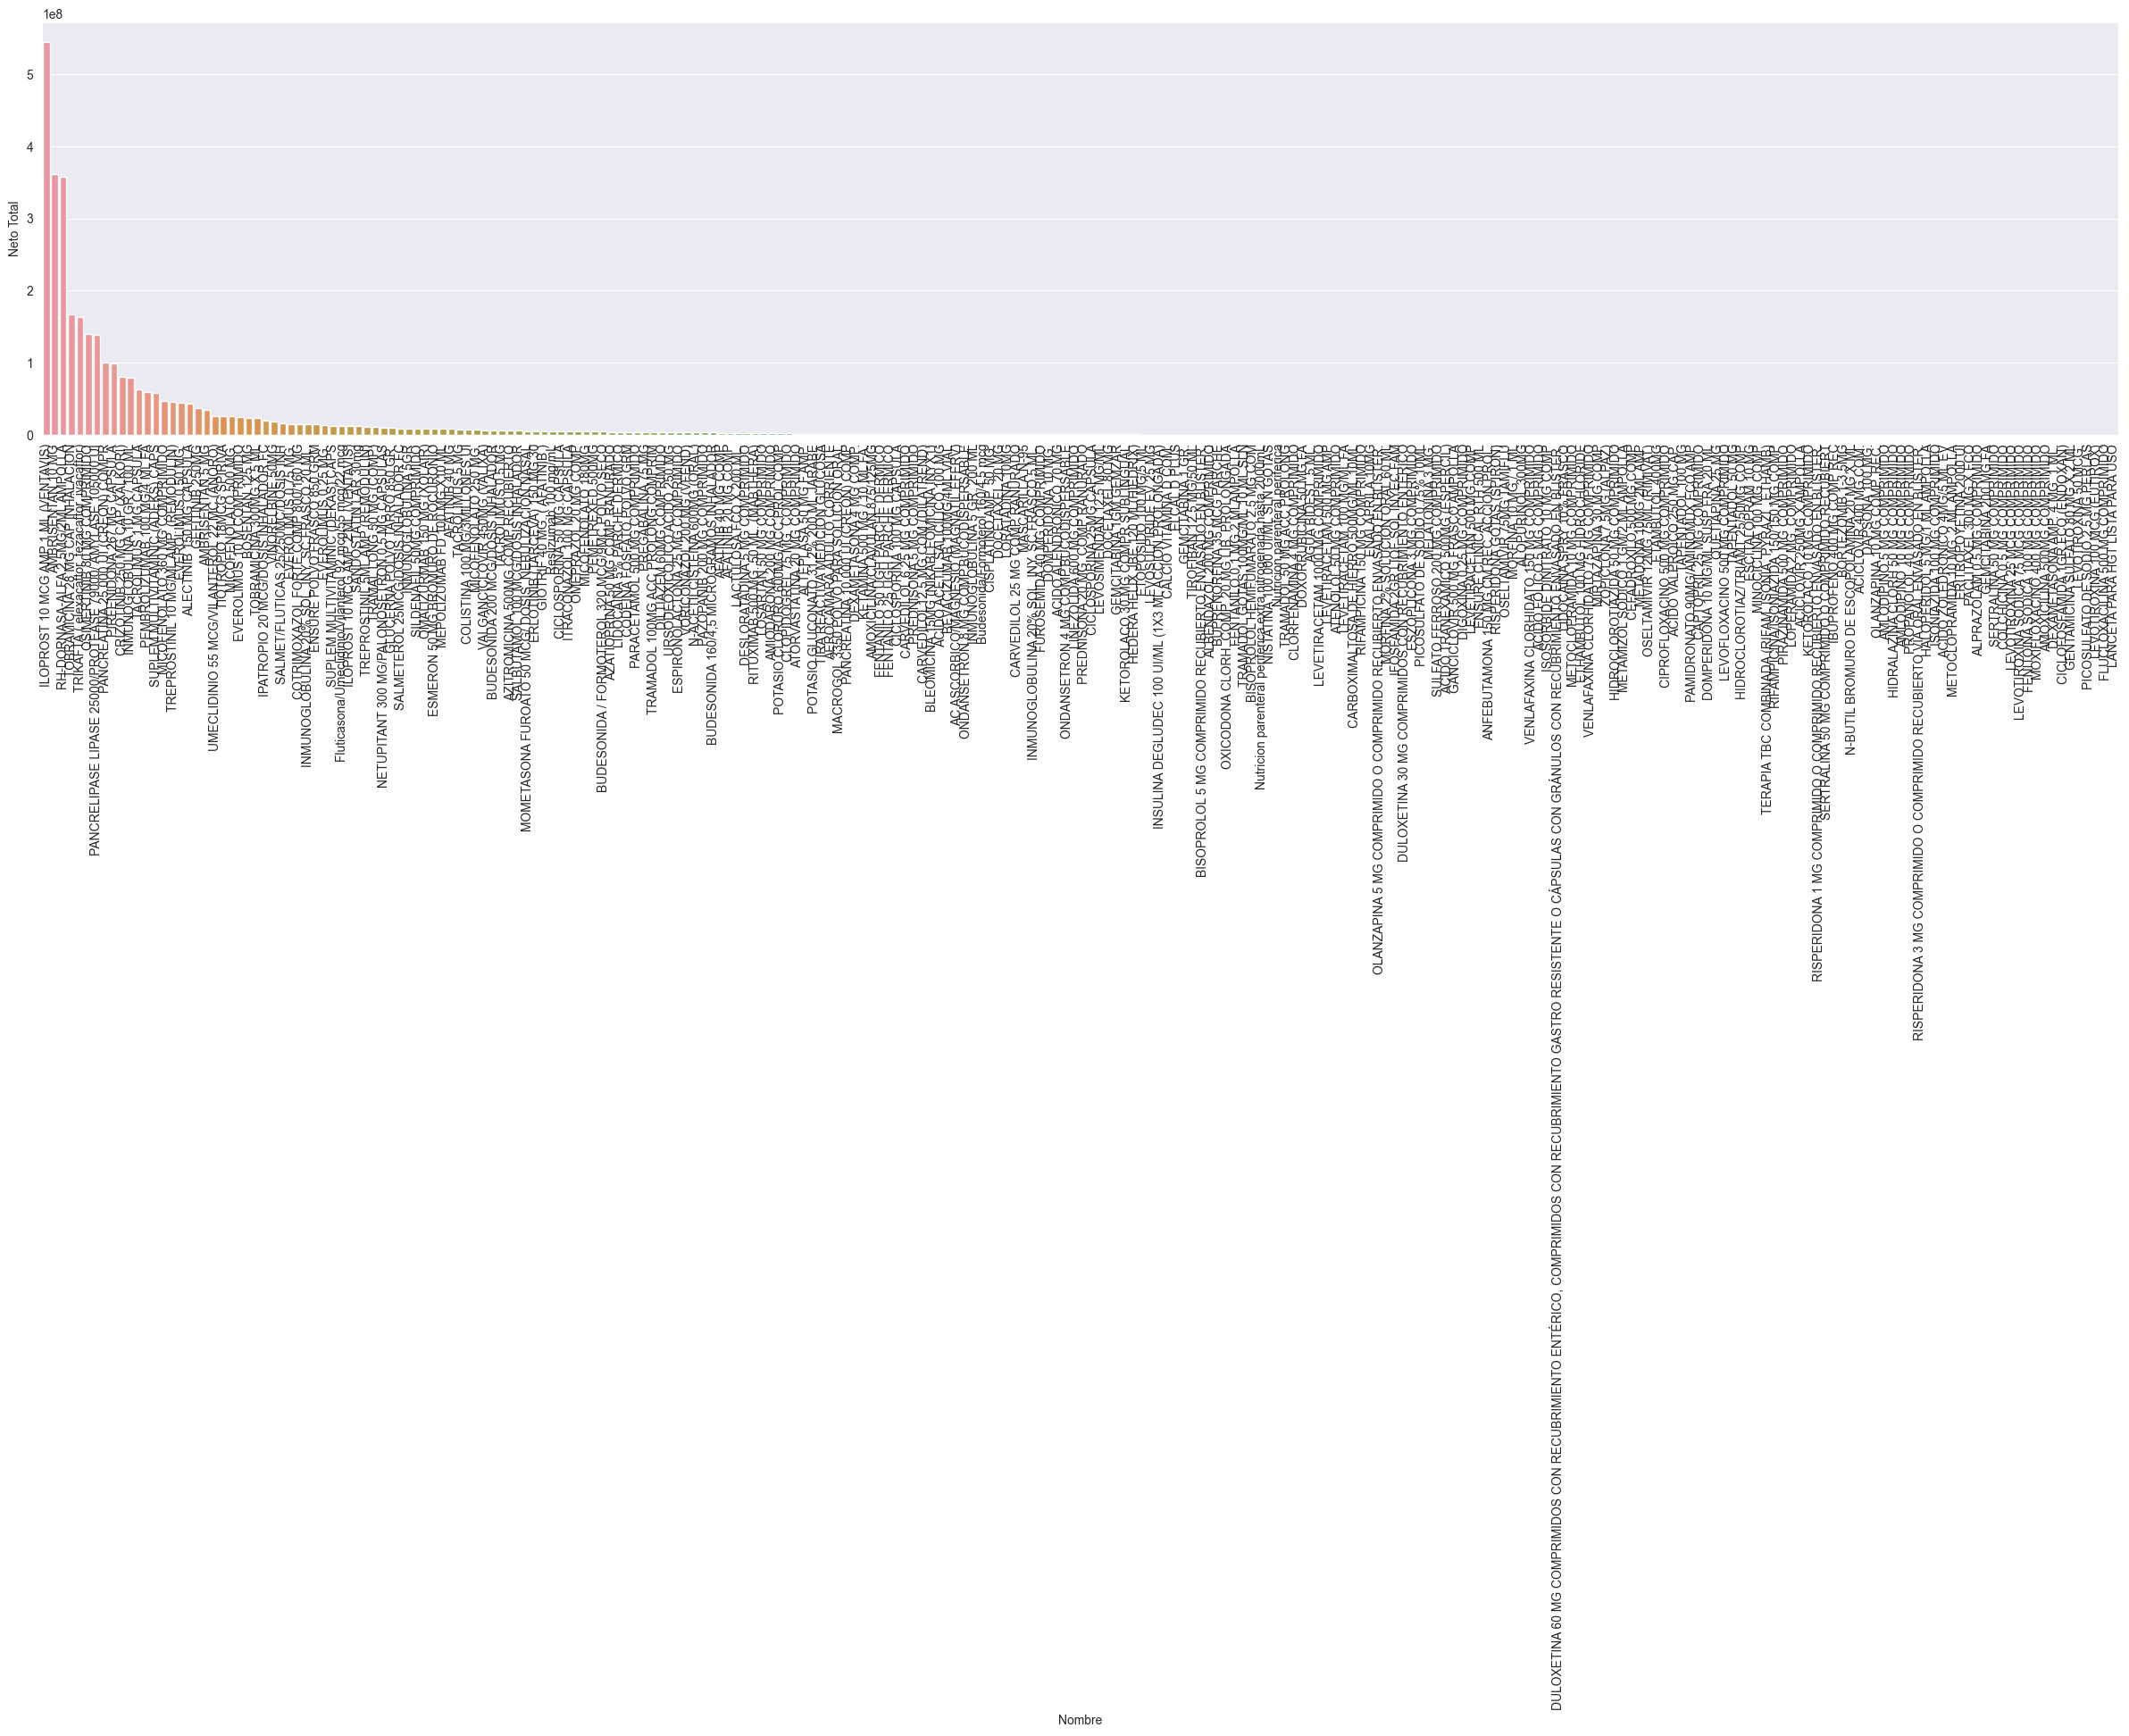

In [176]:
figura_articulos_servicio_suma = plottear(x='Nombre', y='Neto Total', df=articulos_servicio_suma)


## Para efectos de visualización se separarán los datos en cuartiles, y cada cuartil se
## graficara

In [195]:
descripcion_neto_total = articulos_servicio_suma['Neto Total'].describe()
print(f'La distribución de datos de la columna Neto Total es:\n\n'
      f'{descripcion_neto_total}')


La distribución de datos de la columna Neto Total es:

count           246.00
mean     13,515,896.77
std      52,141,162.51
min               0.00
25%         106,282.50
50%         783,800.00
75%       4,693,281.25
max     544,721,562.00
Name: Neto Total, dtype: float64


In [200]:
articulos_qmin = articulos_servicio_suma['Neto Total'].quantile(0)
articulos_q1 = articulos_servicio_suma['Neto Total'].quantile(0.25)
articulos_q2 = articulos_servicio_suma['Neto Total'].quantile(0.5)
articulos_q3 = articulos_servicio_suma['Neto Total'].quantile(0.75)
articulos_qmax = articulos_servicio_suma['Neto Total'].quantile(1)


In [201]:
df_articulos_min_q1 = articulos_servicio_suma.query(
    '`Neto Total` >= @articulos_qmin and `Neto Total` < @articulos_q1')
df_articulos_q1_q2 = articulos_servicio_suma.query(
    '`Neto Total` >= @articulos_q1 and `Neto Total` < @articulos_q2')
df_articulos_q2_q3 = articulos_servicio_suma.query(
    '`Neto Total` >= @articulos_q2 and `Neto Total` < @articulos_q3')
df_articulos_q3_max = articulos_servicio_suma.query(
    '`Neto Total` >= @articulos_q3 and `Neto Total` <= @articulos_qmax')


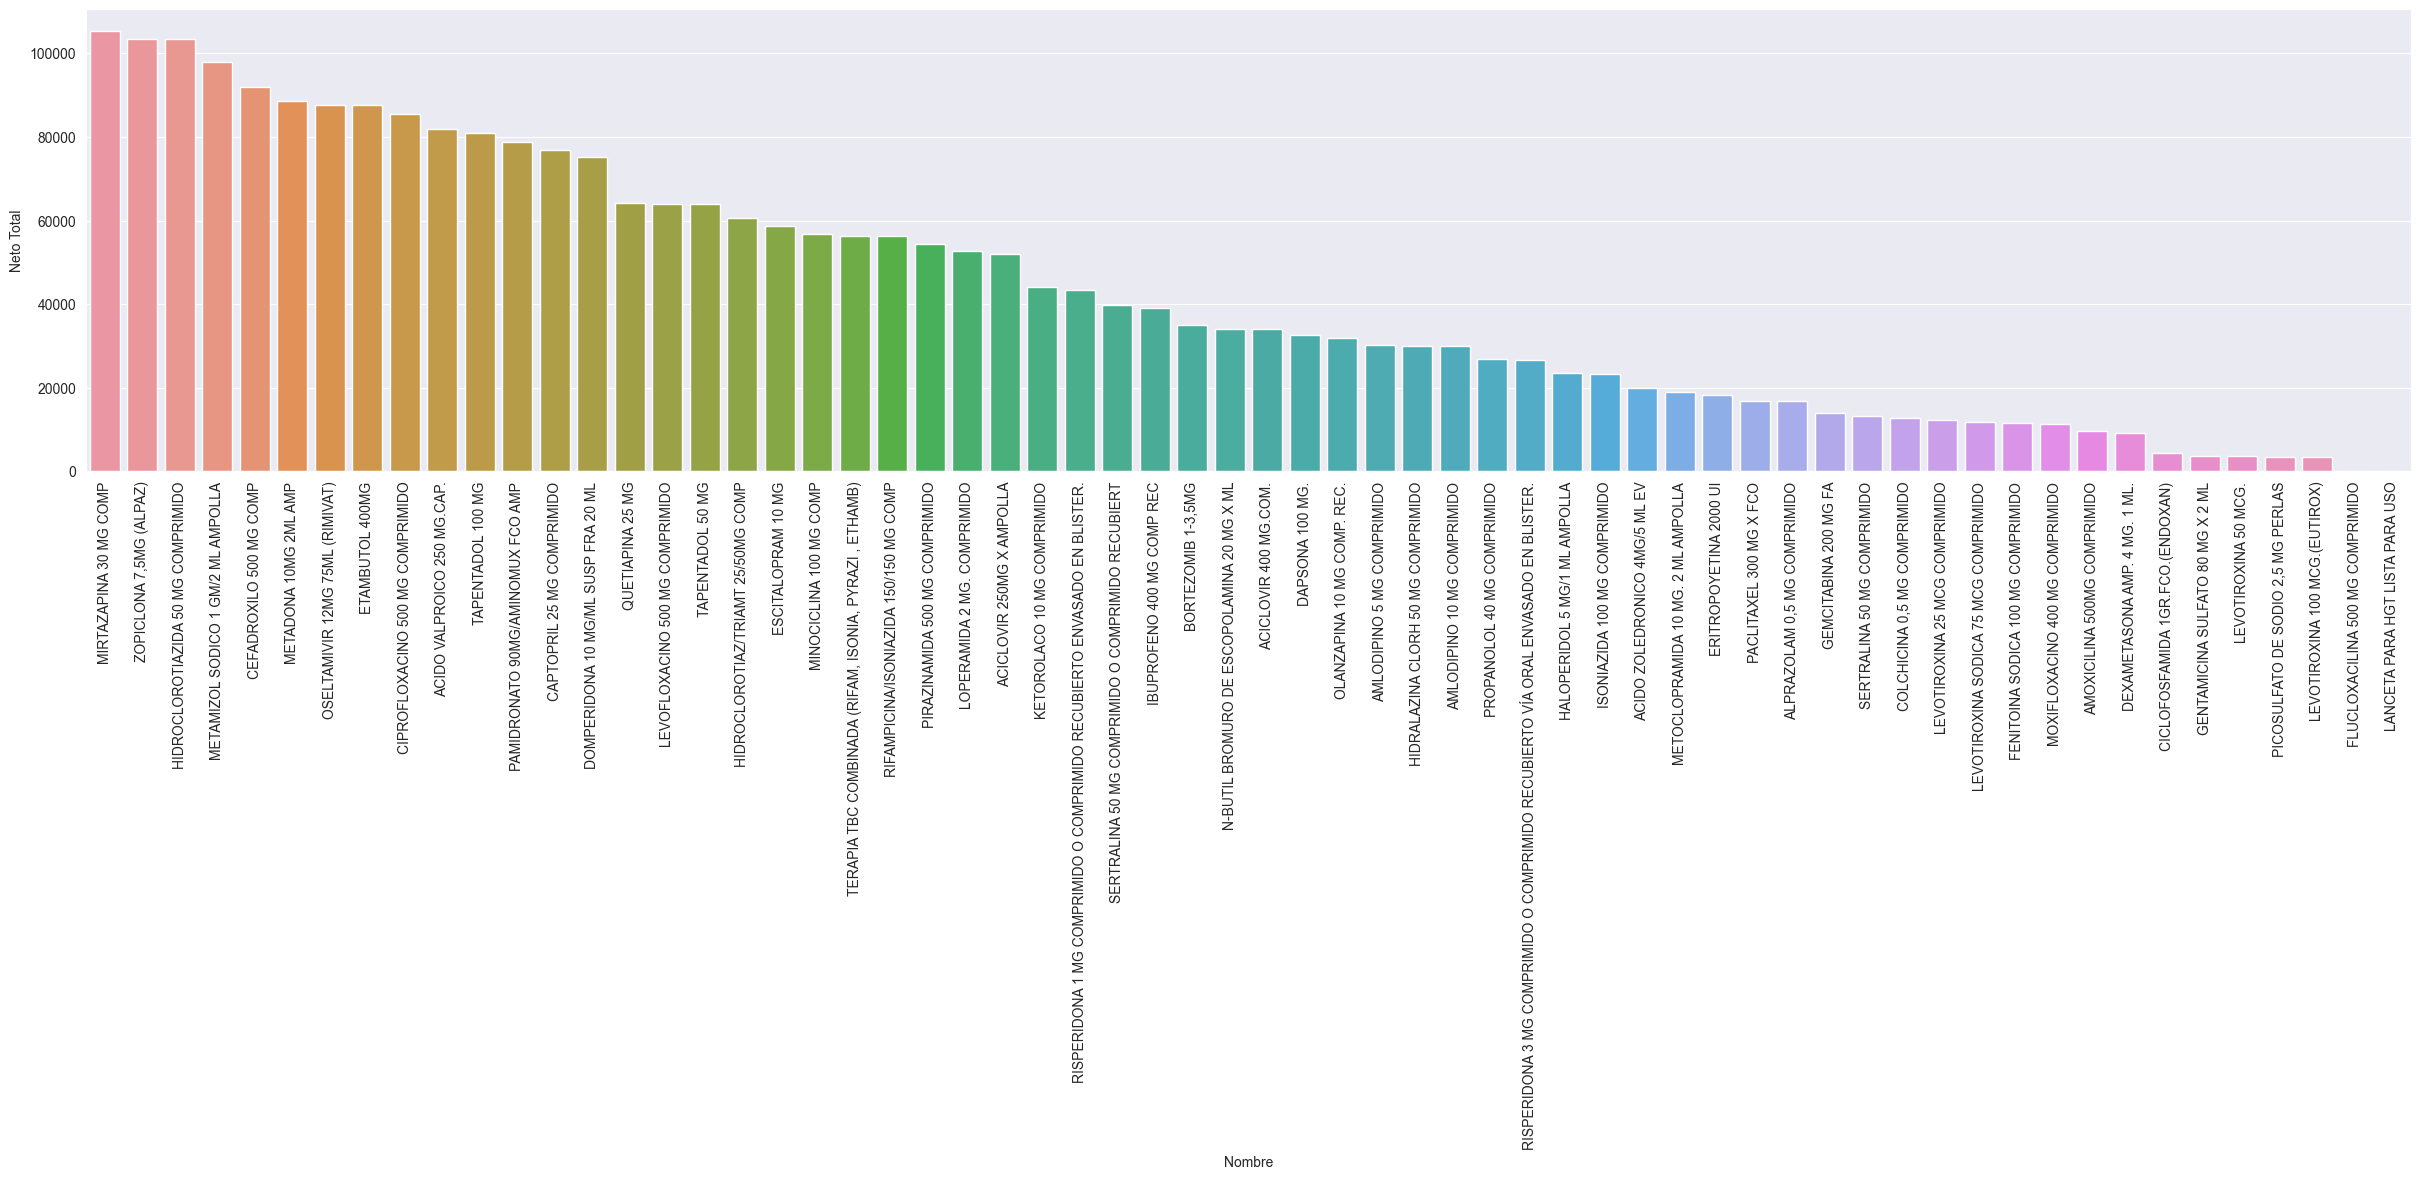

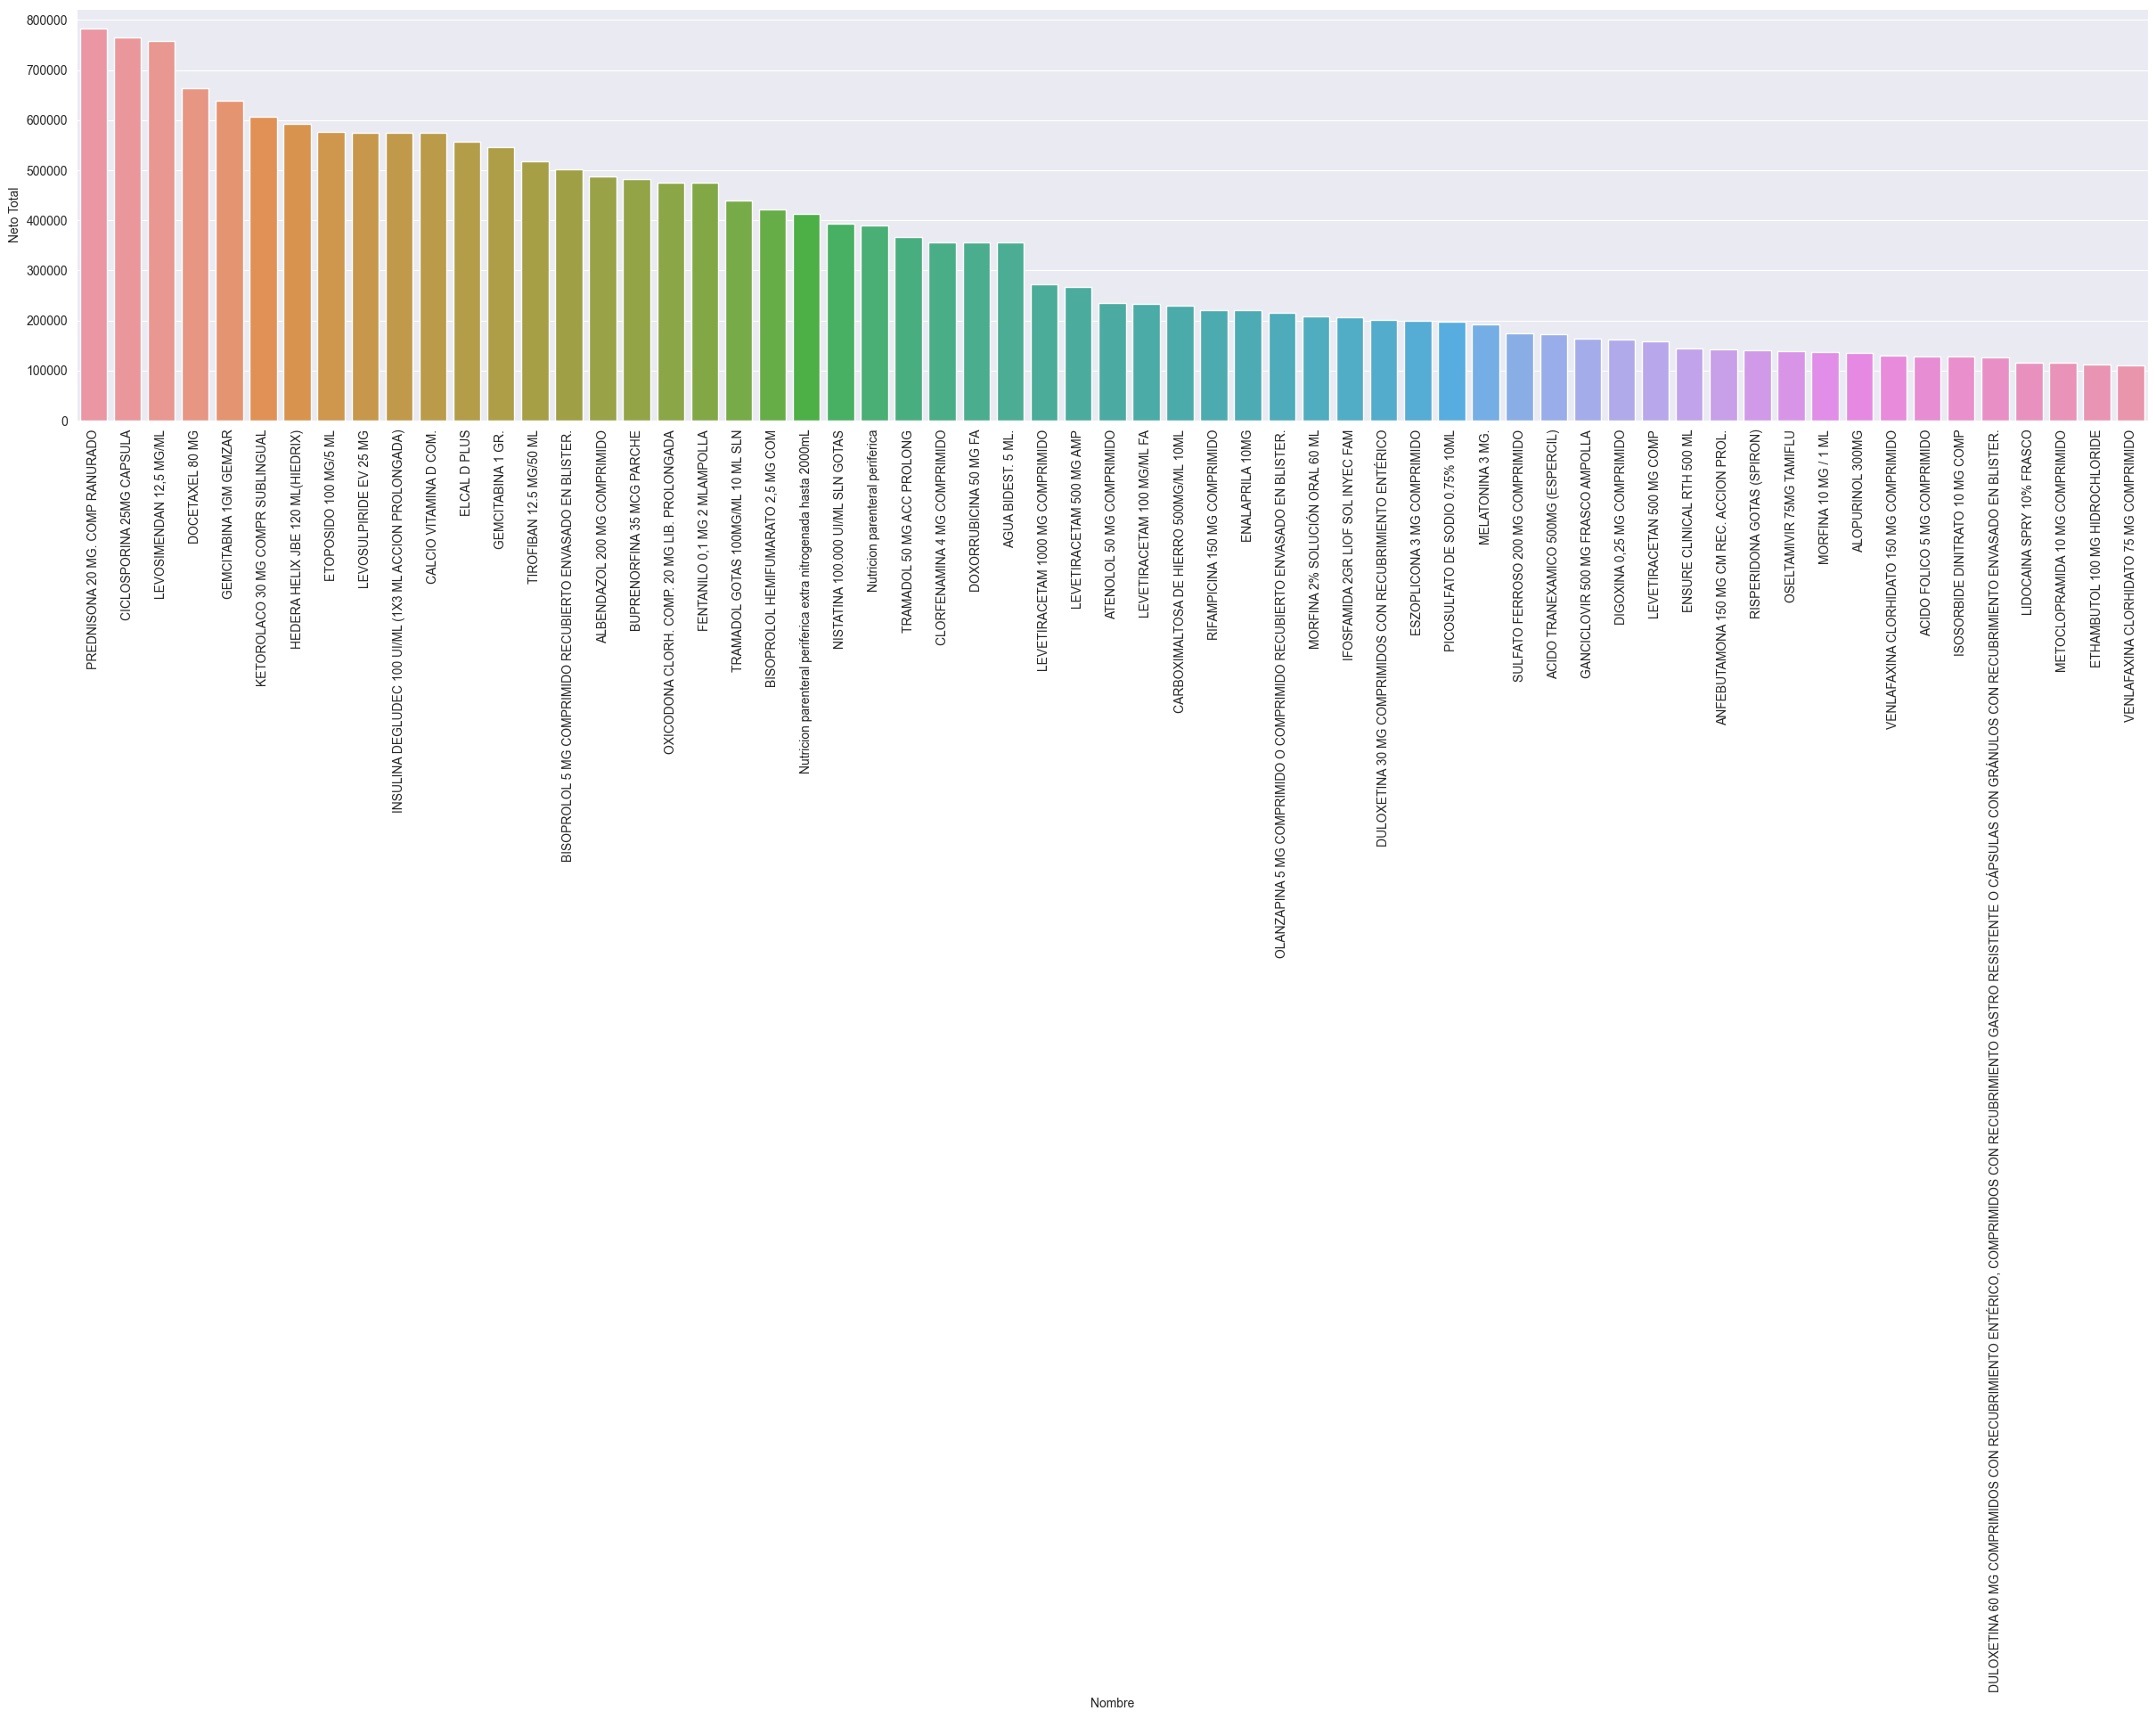

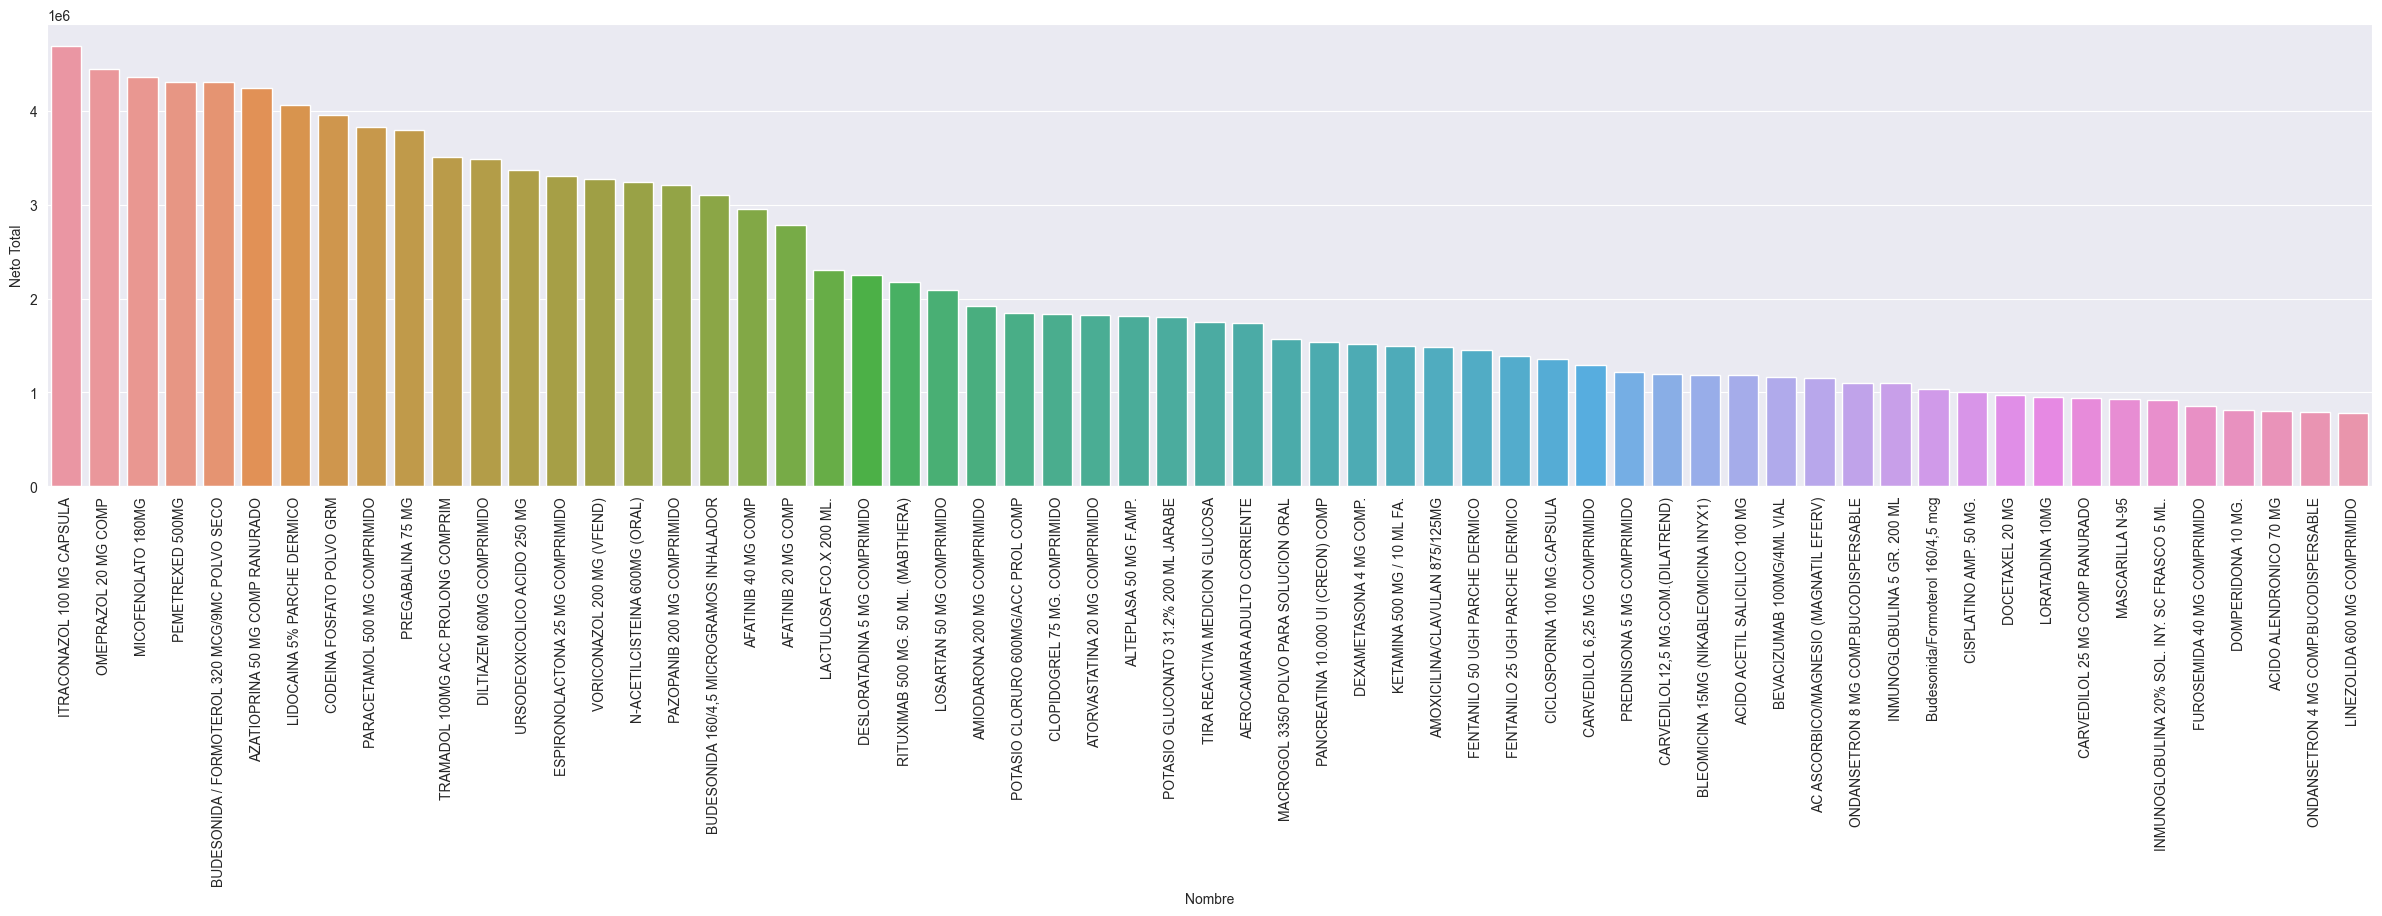

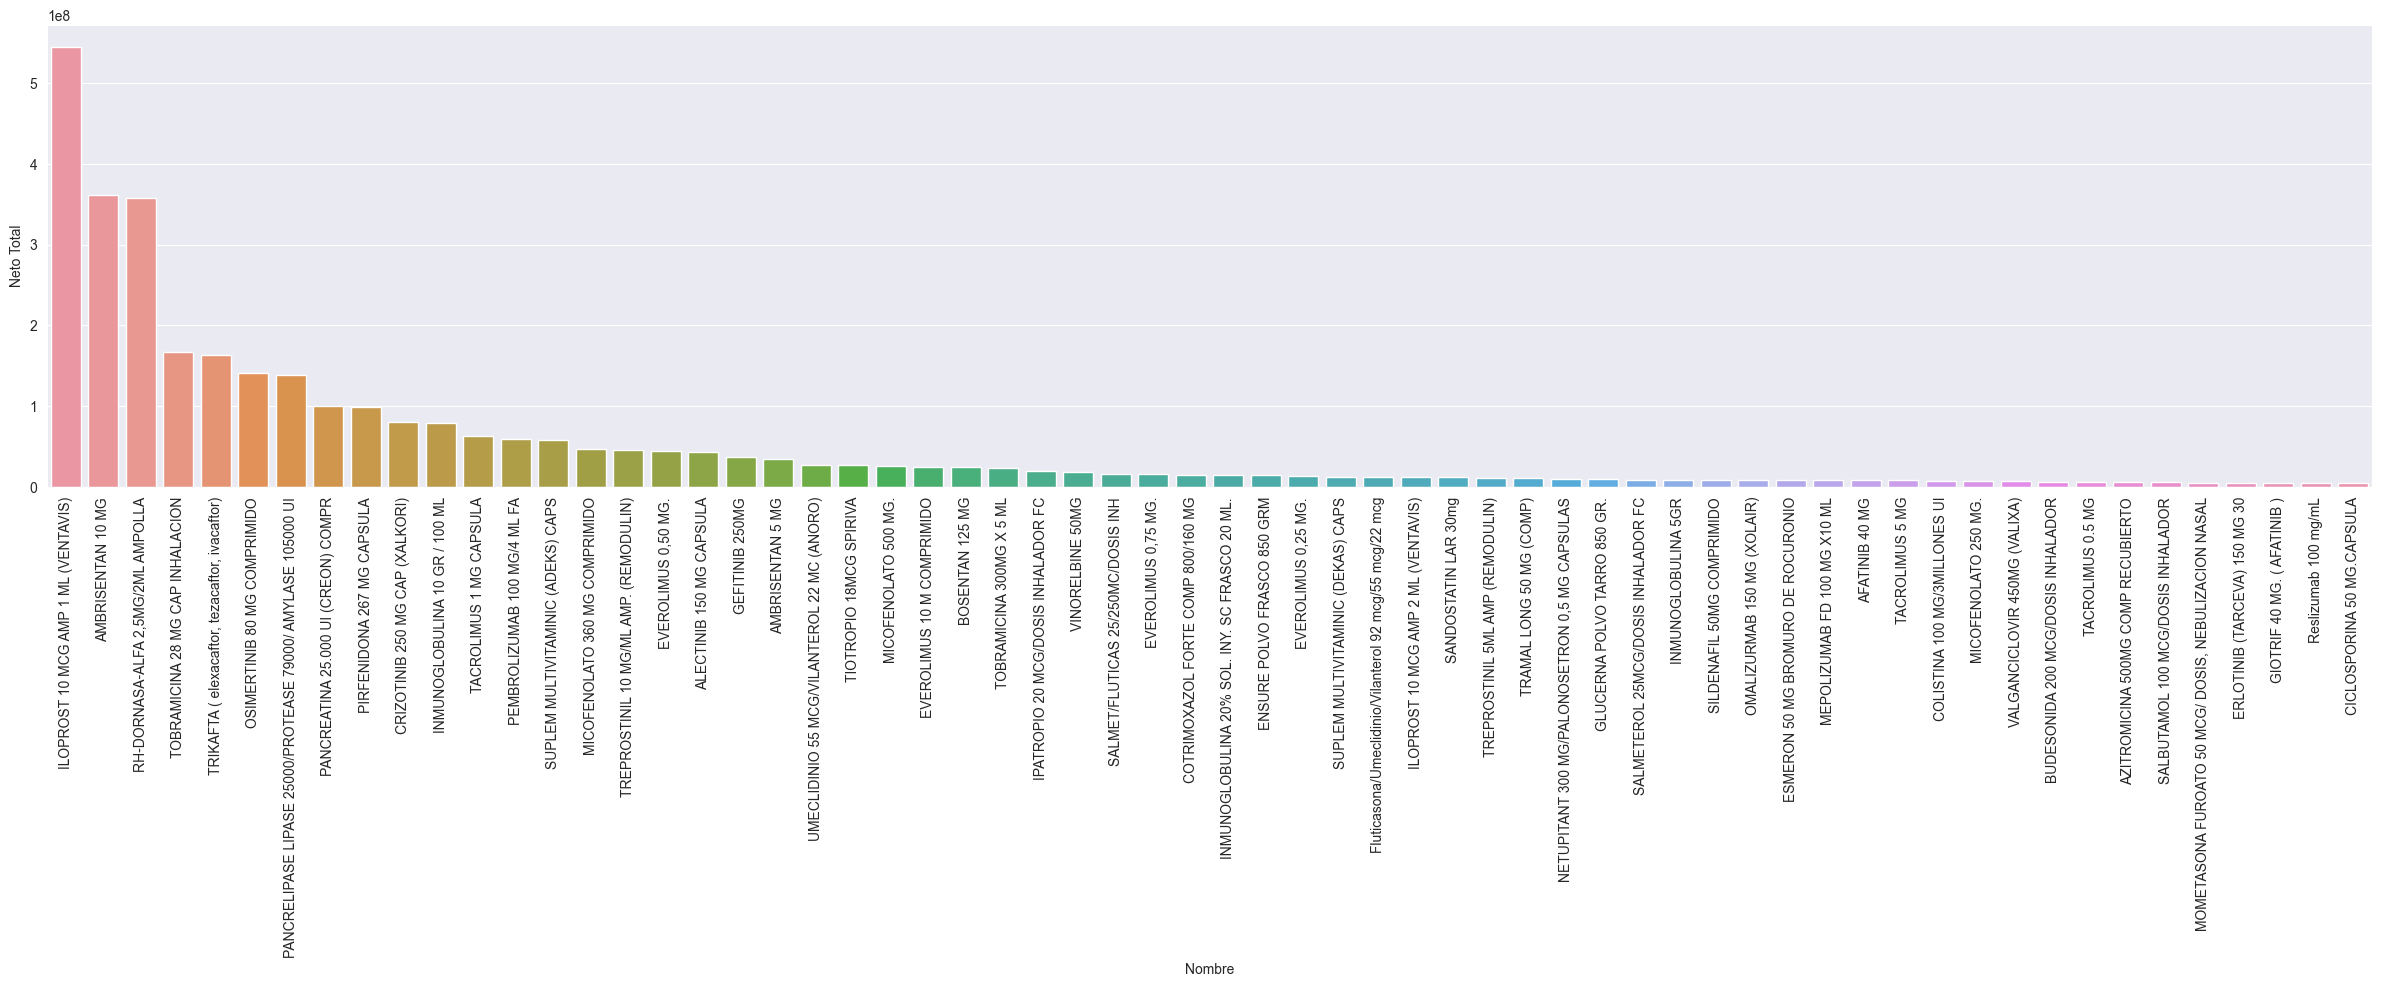

In [210]:
figura_df_articulos_min_q1 = plottear(df_articulos_min_q1, 'Nombre', 'Neto Total')
figura_df_articulos_q1_q2 = plottear(df_articulos_q1_q2, 'Nombre', 'Neto Total')
figura_df_articulos_q2_q3 = plottear(df_articulos_q2_q3, 'Nombre', 'Neto Total')
figura_df_articulos_q3_max = plottear(df_articulos_q3_max, 'Nombre', 'Neto Total')


La distribución de datos de la columna Neto Total es:

count           246.00
mean     13,515,896.77
std      52,141,162.51
min               0.00
25%         106,282.50
50%         783,800.00
75%       4,693,281.25
max     544,721,562.00
Name: Neto Total, dtype: float64


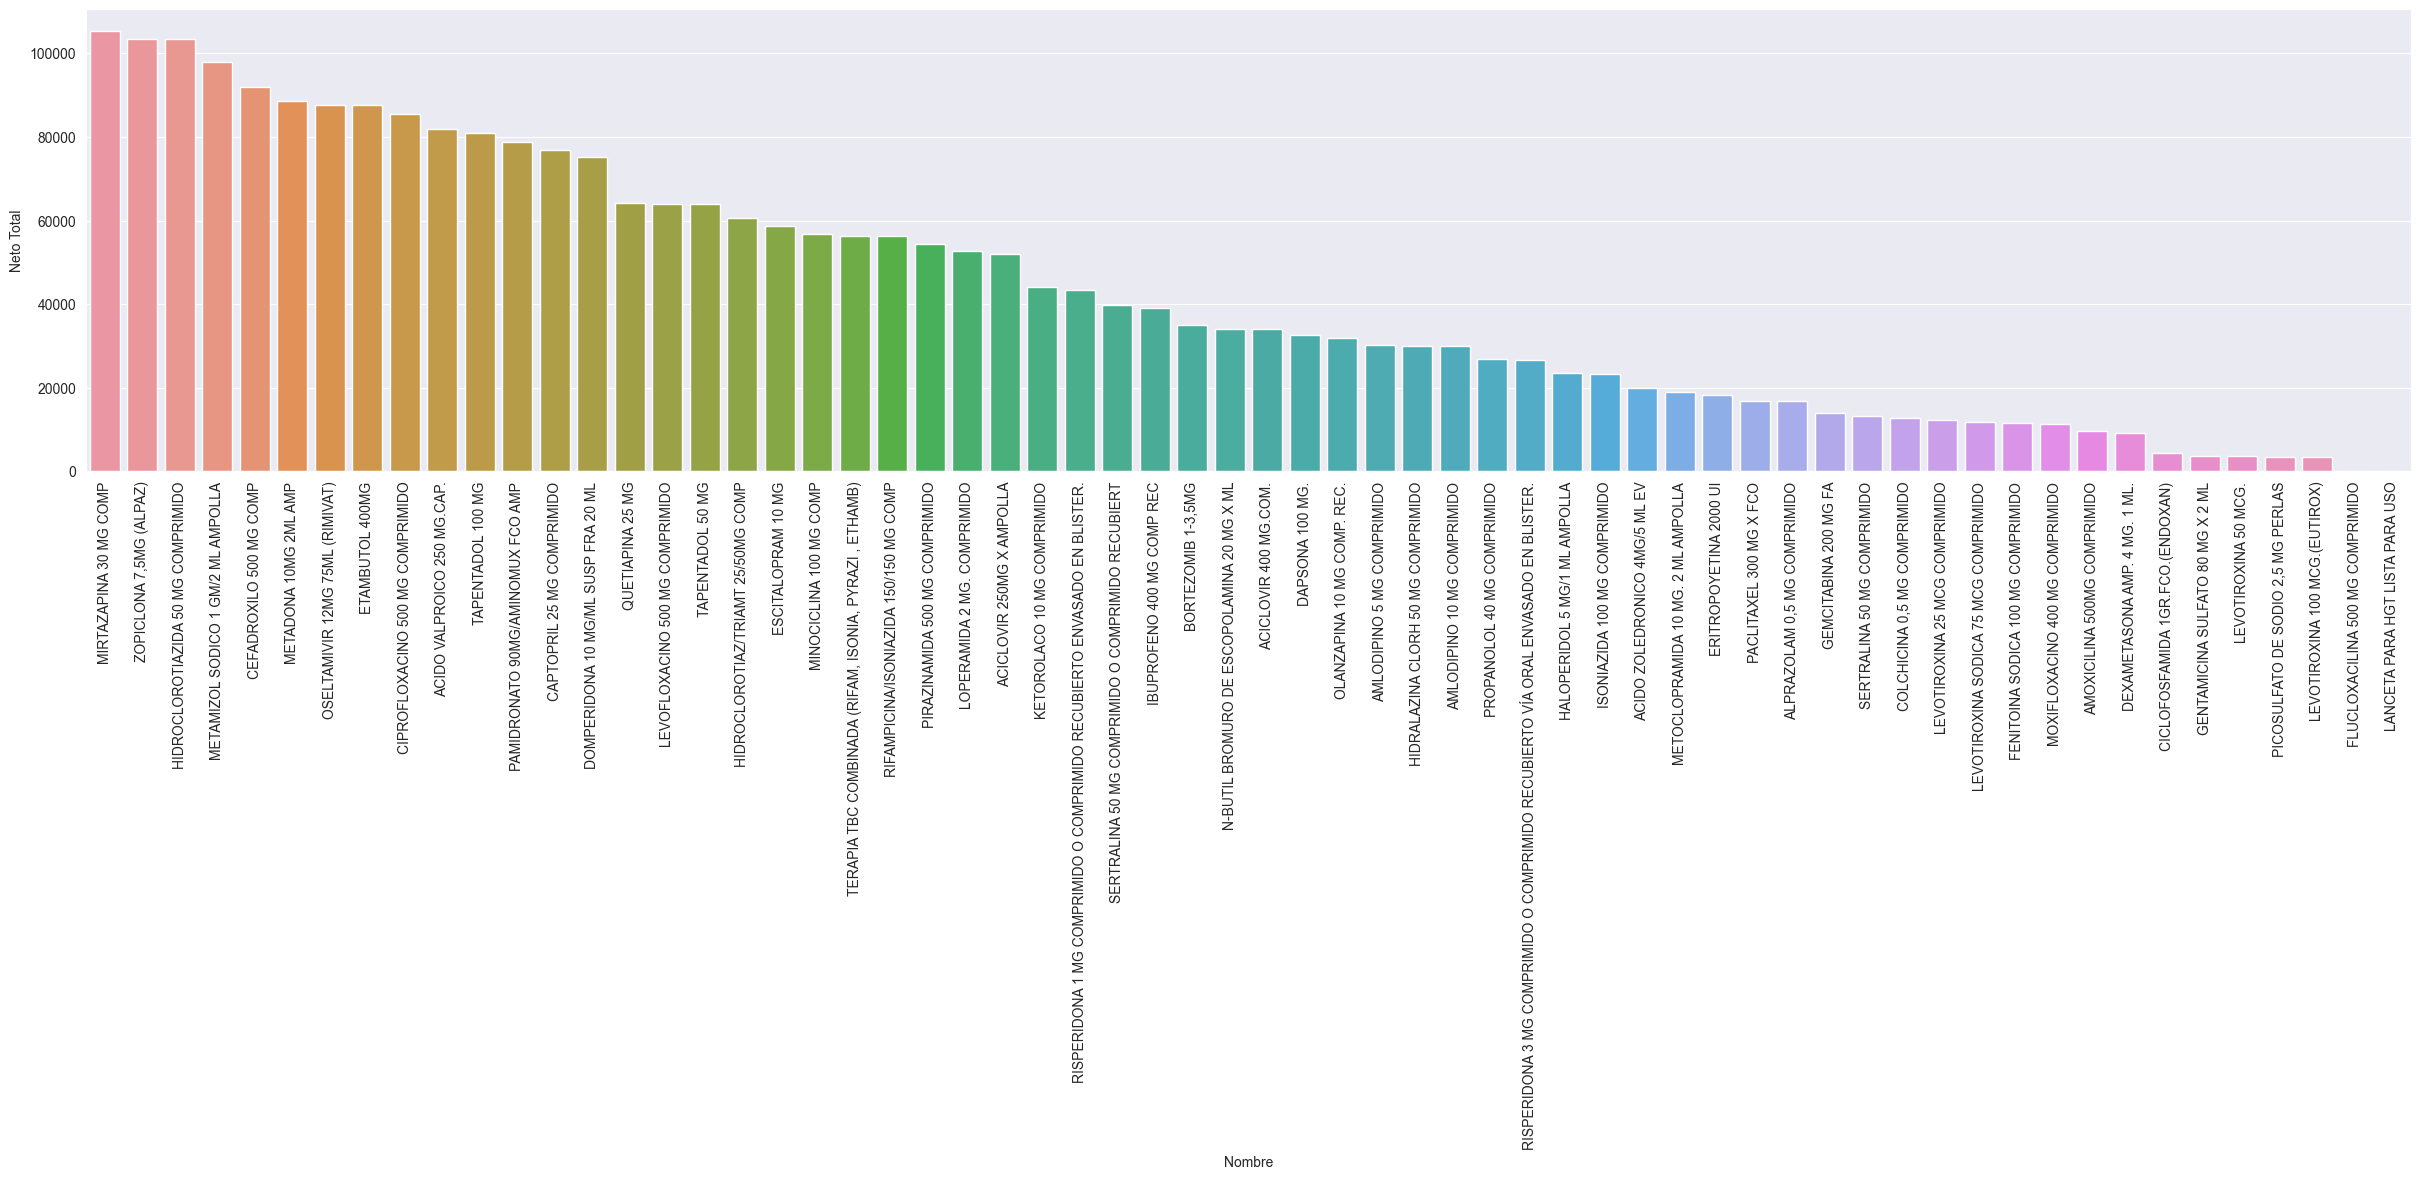

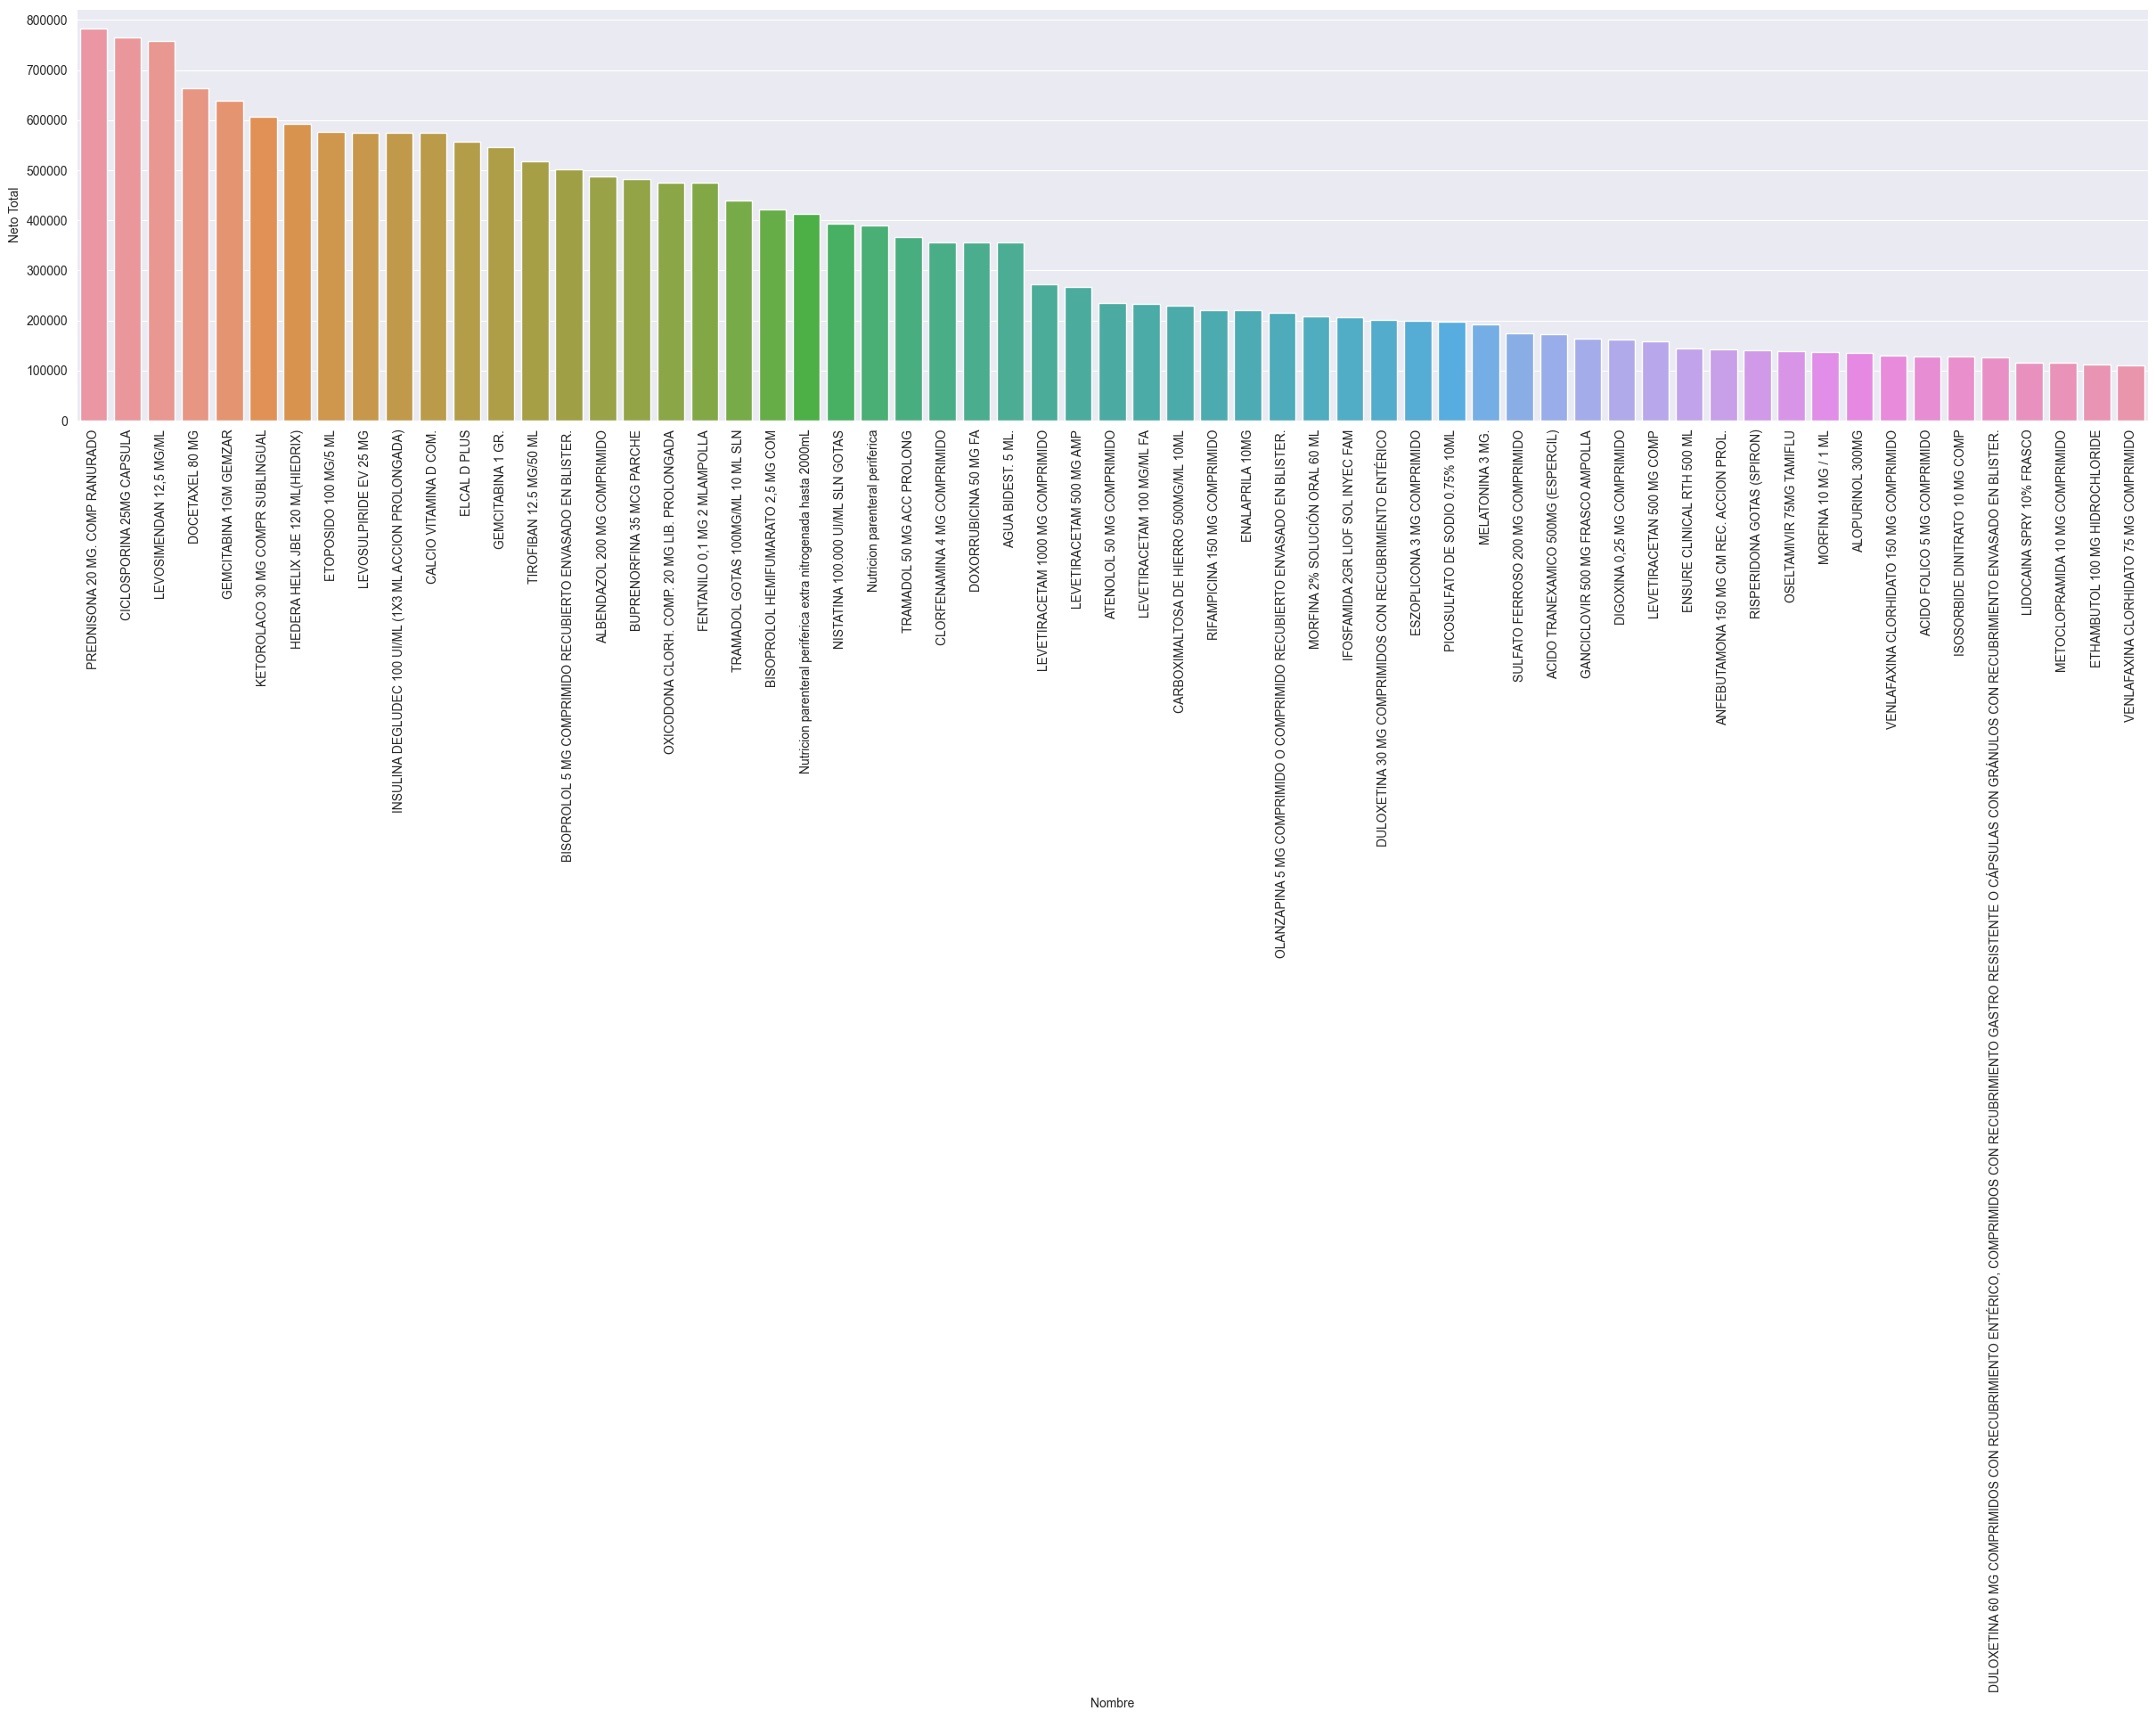

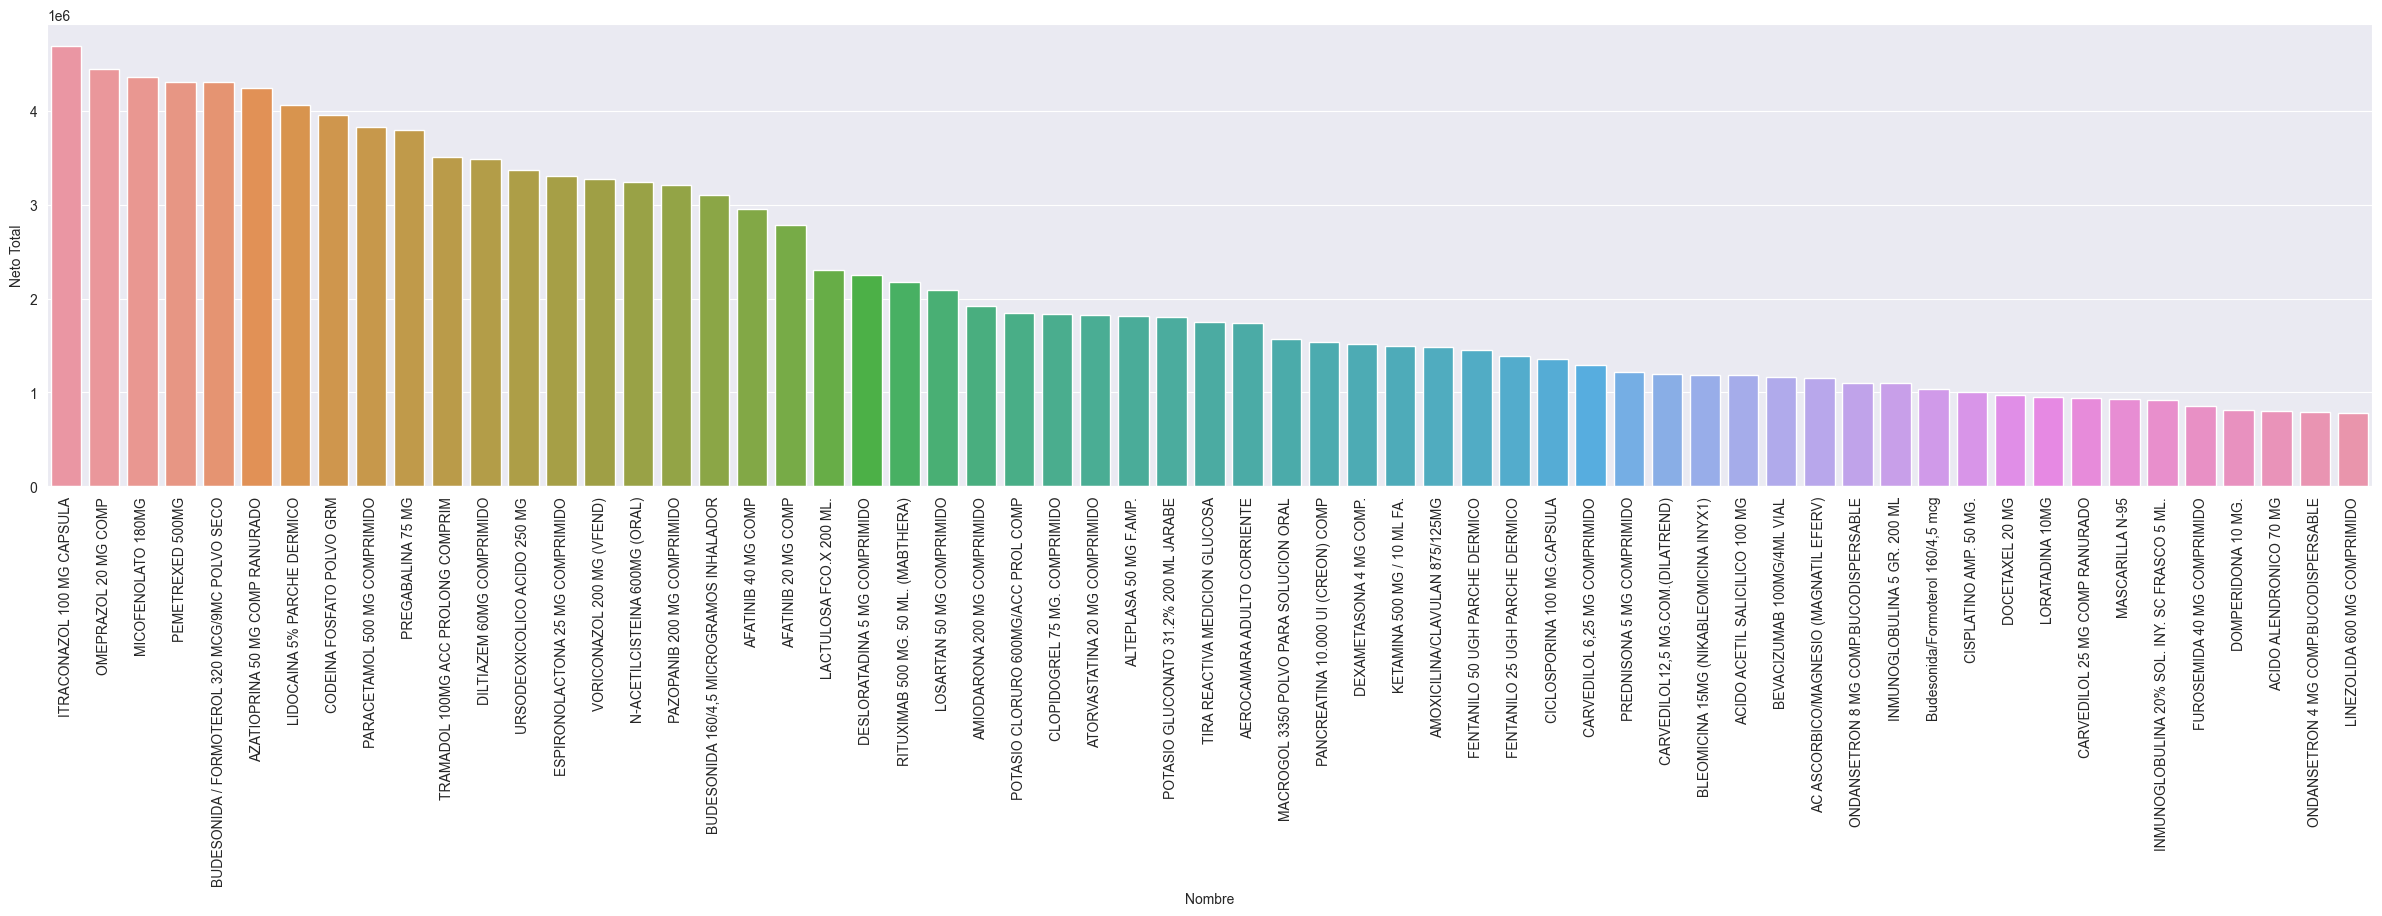

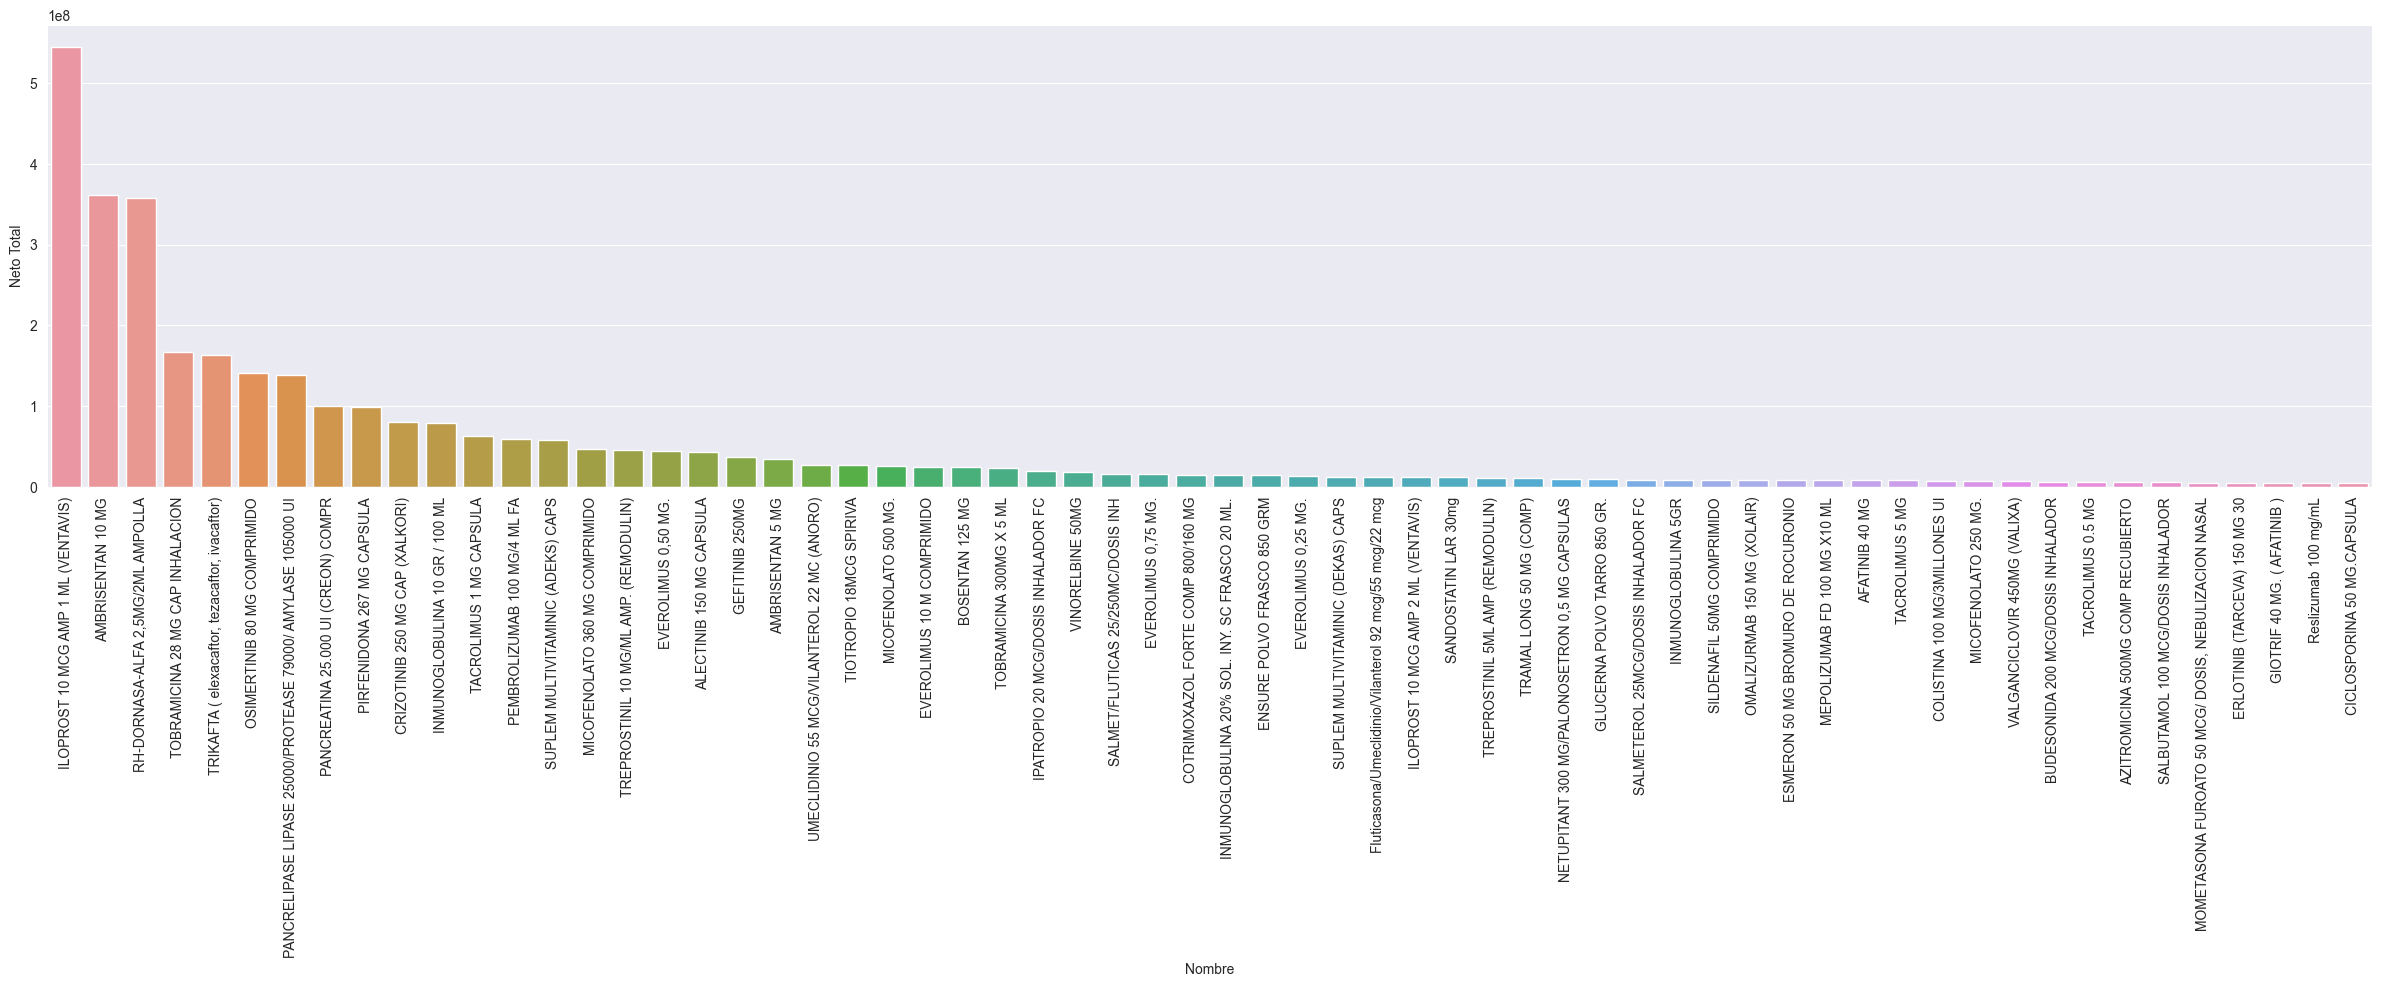

In [215]:


separar_por_cuartil()
